# NYC Apartment Search


_As the end of apartment lease looms, the decision to find a new home becomes paramount. The search for an ideal neighborhood involves a meticulous exploration using NYC Open Data and Zillow's historic rent averages. This project is designed to guide anyone through the process of downloading, cleaning, and analyzing data, aiding in the selection of a neighborhood that aligns with specific criteria—quiet, green, and within budget._

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

## Setup

### Libraries Used

- **Math and File Handling:** Standard Python libraries for basic operations and file path handling.
- **Database Connection:** Tools for connecting to a PostgreSQL database.
- **Web Requests:** The `requests` library for retrieving data from online sources.
- **Geospatial Libraries:** Specialized tools for working with geographical data.
- **Data Analysis:** Libraries like `numpy` and `pandas` for efficient data manipulation.
- **Geospatial Visualization:** Tools like `geopandas` and `geoplot` for creating maps.
- **Visualization Aids:** Libraries like `seaborn` and `matplotlib` for general data visualization.

In [1]:
# Standard Python Libraries
import math
import json
import pathlib
import urllib.parse
import os
from datetime import datetime, date

# PostgreSQL Database Connection
import psycopg2
import psycopg2.extras

# Web Requests
import requests

# Geospatial Libraries
import shapely
import geodatasets
from pyproj import CRS, Transformer
from shapely.ops import transform
from shapely.geometry import Point

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import sqlalchemy as db

# Geospatial Libraries for Data Visualization
import folium
import geopandas as gpd
import geoalchemy2 as gdb
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mapclassify as mc

# Additional Libraries for Visualization
from matplotlib.patches import Circle, Patch
from tabulate import tabulate

# Constants
from sqlalchemy.orm import declarative_base

# File System Paths
from pathlib import PosixPath

# unit test
import pytest
import ipytest

# Type hints
from typing import List, Union, Dict, Tuple
from psycopg2.extensions import connection
from pathlib import Path
from matplotlib.animation import FuncAnimation

### Project Constants and Paths

- **API Token:** A unique token for accessing NYC Open Data.
- **Base Data URL:** The base URL for NYC Open Data resources.
- **Database Configuration:** Connection details for PostgreSQL.
- **Coordinate Reference System (CRS):** Specification for geographical data.
- **File Paths:** Paths for storing and retrieving data.
- **Rent Data Dictionary:** A placeholder for storing rental/month correspondence data.
- **Unique zipcode list:** A placeholder for storing unique zipcode data with proper geometry.

In [2]:
# All constants 

# File Paths
DATA_DIR = pathlib.Path("data") # director for the data
COMPLAINTS_DATE_DIR =  pathlib.Path("data/311_data") # director for the NYC comlpaints data will be saved
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"
QUERY_DIR = pathlib.Path("queries") # directory where DB queries for Part 3 will be saved

# API Token for NYC Open Data
APP_TOKEN = "noFU7vdLMu3RKtmWOyOqkOi2x"

# Base URL for NYC Open Data
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/resource/"

# NYC Open Data Datasets
NYC_DATA_311 = "erm2-nwe9.json"
NYC_DATA_TREES = "5rq2-4hqu.json"
NYC_DATA_BUSINESS = "w7w3-xahh.json"

# Database Configuration
DB_NAME = "Final_Project"
DB_USER = "postgres"
DB_PASSWORD = "Sml123321"
DB_SCHEMA_FILE = "schema.sql"

# Coordinate Reference System (CRS)
CRS='EPSG:4326'

# Rent Data Dictionary
rent_month_dict = {}
unique_zipcodes = []

**Query Directory:** Crete the directory for storing SQL queries.

In [3]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

**Objective:**
Load, clean and view of all relevant datasets for further analysis. This includes zipcode data, 311 complaints data, tree data, and Zillow rental data.

### Instructions:

1. Run the `load_and_clean_zipcodes` function with the `ZIPCODE_DATA_FILE` path to load and clean the zipcode data.
2. Run the `download_and_clean_311_data` function to download and clean the 311 complaints data.
3. Run the `download_and_clean_tree_data` function to download and clean the tree data.
4. Run the `load_and_clean_zillow_data` function with the `ZILLOW_DATA_FILE` path to load and clean the Zillow rental data.
5. Execute the `load_all_data` function to load and clean all datasets, providing GeoDataFrames and DataFrames for further analysis.

Make sure to follow the order of functions as listed above to ensure dependencies are met. After running these functions, you'll have cleaned datasets ready for exploration in subsequent parts of the project.

In [118]:
def download_nyc_311_data(url: str, force: bool = False) -> List[Path]:
    """
    Download NYC 311 data from the specified URL and store it in 35 JSON files.

    Args:
        url (str): The URL to download the data from.
        force (bool): If True, force download even if the file already exists.

    Returns:
        list: List of Path for downloaded 311 complaints files.
    """
    json_files = [f"{i}.json" for i in range(35)]
    filenames = [COMPLAINTS_DATE_DIR / i for i in json_files ]
    
    if not COMPLAINTS_DATE_DIR.exists():
        COMPLAINTS_DATE_DIR.mkdir()
    
    all_entries = []
    limit = 1_000_000 # the limit of entries get from the url at each time
    for filename in filenames:
        if force or not filename.exists():
            print(f"Downloading {url} to {filename}...")
            offset = int(filename.stem) * 1_000_000
            selected_columns = ["unique_key", "created_date", "complaint_type", "incident_zip", "location"]
            soql_query = f"{url}?$$app_token={APP_TOKEN}&$select={','.join(selected_columns)}&$limit={limit}&$offset={offset}"
            response = requests.get(soql_query)
            
            if response.status_code == 200: 
                entries = response.json()
                with open(filename, "w") as f:
                    json.dump(entries, f)

                print(f"Done downloading {filename}.")
   
            else:
                print(f"cannot access url error code{response.status_code}")
                raise ConnectionError("Failed to access the URL")

    print(f"start reading data from {filenames[0]} to {filenames[-1]}...")
    return filenames

In [5]:
def download_nyc_tree_data(url: str, force: bool = False) -> Path:
    """
    Download NYC tree data from the specified URL and store it in a JSON file.

    Args:
        url (str): The URL to download the data from.
        force (bool): If True, force download even if the file already exists.

    Returns:
        Path: File Path of the downloaded tree data.
    """
    url_path = urllib.parse.urlparse(url).path.split('/')[-1]
    filename = DATA_DIR / url_path
    
    if not DATA_DIR.exists():
        DATA_DIR.mkdir()

    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")        
        limit = 1_000_000
        selected_columns = ["created_at", "tree_id", "zipcode", "the_geom", "spc_common", "health", "status"]
        soql_query = f"{url}?$$app_token={APP_TOKEN}&$select={','.join(selected_columns)}&$limit={limit}"
        response = requests.get(soql_query)
        if response.status_code == 200: 
            entries = response.json()
            with open(filename, "w") as f:
                json.dump(entries, f)
            print(f"Done downloading {url}.")
        else:
            print(f"cannot access url error code{response.status_code}")
            raise ConnectionError("Failed to access the URL")     
    else:
        print(f"Reading from {filename}")

    return filename

In [6]:
def download_and_clean_311_data() -> gpd.GeoDataFrame:
    """
    Download and clean NYC 311 data from url, converting it into a GeoDataFrame.

    Returns:
        geopandas.GeoDataFrame: Cleaned GeoDataFrame with 311 data for New York City.
    """
    
    service_requests_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_311}"
    filenames = download_nyc_311_data(service_requests_url)
    
    interactions_geo_data_frame_list = []
    
    # Iterate through each file in the directory
    for filename in filenames:
        
        
        interactions_geo_data_frame = gpd.GeoDataFrame(pd.read_json(filename, dtype='object'))
    
        if 'location' in interactions_geo_data_frame.columns:
  
                interactions_geo_data_frame['longitude'] = interactions_geo_data_frame['location'].apply(
                    lambda loc: loc.get('longitude') if isinstance(loc, dict) else None
                )
                interactions_geo_data_frame['latitude'] = interactions_geo_data_frame['location'].apply(
                    lambda loc: loc.get('latitude') if isinstance(loc, dict) else None
                )

                geometry = gpd.GeoSeries(
                    interactions_geo_data_frame.apply(
                        lambda row: Point(float(row['longitude']), float(row['latitude'])) if not pd.isna(row['longitude']) and not pd.isna(row['latitude']) else None,
                        axis=1
                    ),
                    crs=CRS
                )

        if 'location' in interactions_geo_data_frame.columns:
                interactions_geo_data_frame.drop(columns=['location'], inplace=True)
        if 'longitude' in interactions_geo_data_frame.columns:
                interactions_geo_data_frame.drop(columns=['longitude'], inplace=True)
        if 'latitude' in interactions_geo_data_frame.columns:
                interactions_geo_data_frame.drop(columns=['latitude'], inplace=True)
    
        interactions_geo_data_frame.set_geometry(geometry, inplace=True)
        
        interactions_geo_data_frame = interactions_geo_data_frame.dropna(subset=['incident_zip'])
        interactions_geo_data_frame = interactions_geo_data_frame[interactions_geo_data_frame["incident_zip"].isin(unique_zipcodes)]

        interactions_geo_data_frame['created_date'] = pd.to_datetime(interactions_geo_data_frame['created_date'], format='%Y-%m-%dT%H:%M:%S.%f')
        # append each gdf to gdf list
        interactions_geo_data_frame_list.append(interactions_geo_data_frame)

    
    gdf_complaints = gpd.GeoDataFrame(pd.concat(interactions_geo_data_frame_list, ignore_index=True, sort=True))
    
    gdf_complaints.crs = interactions_geo_data_frame_list[0].crs
    interactions_geo_data_frame_list.clear() # clear the list to free memory space
    gdf_complaints = gdf_complaints.drop_duplicates(subset=['unique_key']).reset_index(drop=True)
    
    
    gdf_complaints.rename(columns={"incident_zip": "zipcode", "geometry": "location"}, inplace=True)
    gdf_complaints = gpd.GeoDataFrame(gdf_complaints, geometry='location')
    return gdf_complaints

In [7]:
def download_and_clean_tree_data() -> gpd.GeoDataFrame:
    """
    Download and clean NYC tree data, converting it into a GeoDataFrame.

    Returns:
        geopandas.GeoDataFrame: Cleaned GeoDataFrame with tree data for New York City.
    """
    trees_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_TREES}"
    filename = download_nyc_tree_data(trees_url)
    trees_gdf = gpd.GeoDataFrame(pd.read_json(filename), dtype='object')
    convert_dict = {
        "tree_id" : int,
        "spc_common" :str,
        "health": str,
        "status": str,
        "the_geom" : "geometry",
        "zipcode":str
    }
    
    trees_gdf['the_geom'] = gpd.GeoSeries(
        trees_gdf['the_geom'].apply(lambda x: Point(x['coordinates'])), crs=CRS
    )
    
    trees_gdf_normalized = gpd.GeoDataFrame(trees_gdf.astype(convert_dict))
    trees_gdf_normalized['created_at'] = pd.to_datetime(trees_gdf_normalized['created_at'], format='%Y-%m-%dT%H:%M:%S.%f')
    trees_gdf_normalized = gpd.GeoDataFrame(trees_gdf_normalized[trees_gdf_normalized["zipcode"].isin(unique_zipcodes)])
    trees_gdf_normalized = trees_gdf_normalized.reset_index(drop=True)
    trees_gdf_normalized.rename(columns={"created_at": "created_date", 
                                         "spc_common": "species", 
                                         "the_geom": "location"}, inplace=True)
    trees_gdf_normalized = gpd.GeoDataFrame(trees_gdf_normalized, geometry='location')
    return trees_gdf_normalized

In [8]:
def load_and_clean_zipcodes(zipcode_datafile: Path) -> gpd.GeoDataFrame:
    """
    Load and clean zip code data from a shapefile.

    Args:
        zipcode_datafile (Path): The path to the shapefile containing zip code data.

    Returns:
        geopandas.GeoDataFrame: Cleaned GeoDataFrame with unique zip codes and corresponding geometries for New York City.
    """ 
    global unique_zipcodes
    if not zipcode_datafile.exists():
        raise FileNotFoundError(f"The file path {zipcode_datafile} is invalid.")
    
    gdf_zipcode = gpd.read_file(zipcode_datafile, index_col=0)
    gdf_zipcode.to_crs(4326, inplace=True)
    gdf_zipcode_nor = gdf_zipcode[["ZIPCODE", "geometry"]].copy()
    unique_zipcodes_gdf = gdf_zipcode_nor.drop_duplicates(subset = ["ZIPCODE"], keep = "last").reset_index(drop=True)
    unique_zipcodes = unique_zipcodes_gdf["ZIPCODE"]
    
    unique_zipcodes_gdf.rename(columns={"ZIPCODE": "zipcode"}, inplace=True)
    return unique_zipcodes_gdf

In [9]:
def load_and_clean_zillow_data(zillow_datafile) -> pd.DataFrame:
    """
    Load and clean Zillow rental data for New York.

    Args:
        ZILLOW_DATA_FILE (Path): Path to the Zillow rental data file.

    Returns:
        pandas.DataFrame: Cleaned DataFrame with Zillow rental data for New York City.
    """
    global rent_month_dict
    
    if not zillow_datafile.exists():
        raise FileNotFoundError(f"The file path {zillow_datafile} is invalid.")

    zillow_rent_data = pd.read_csv(zillow_datafile)
    rent_data = zillow_rent_data[zillow_rent_data["City"] == "New York"]
    rent_data = rent_data.reset_index(drop=True)
    rent_data = rent_data.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])
    column_names = rent_data.columns.tolist()
    for i,j in enumerate(column_names): # Assign value to rent_month_dict in order to match rent to specfic month retrieve from db
        if i > 0:
            rent_month_dict[j] = i-1
    
    rent_data.rename(columns={"RegionName": "zipcode"}, inplace=True)  
    return rent_data

In [10]:
def load_all_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame, pd.DataFrame]:
    """
    Load and clean all relevant datasets.

    Returns:
        tuple: Tuple containing GeoDataFrames and DataFrames for zipcode, 311, trees, and Zillow rental data.
    """
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    print(f"load zipcode data done")
    geodf_311_data = download_and_clean_311_data()
    print(f"load 311 data done")
    geodf_tree_data = download_and_clean_tree_data()
    print(f"load trees data done")
    df_zillow_data = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    print(f"load rents data done")
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [11]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

load zipcode data done
start reading data from data/311_data/0.json to data/311_data/34.json...
load 311 data done
Reading from data/5rq2-4hqu.json
load trees data done
load rents data done


#### Show basic info about each DataFrame:

Let's take a quick look at the loaded dataframes:

In [12]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    object  
 1   geometry  248 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.0+ KB


In [13]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [14]:
geodf_zipcode_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33367932 entries, 0 to 33367931
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   complaint_type  object        
 1   created_date    datetime64[ns]
 2   location        geometry      
 3   zipcode         object        
 4   unique_key      object        
dtypes: datetime64[ns](1), geometry(1), object(3)
memory usage: 1.2+ GB


In [16]:
geodf_311_data.head()

,complaint_type,created_date,location,zipcode,unique_key
0,Derelict Vehicles,2023-12-02 12:00:00,POINT (-73.87298 40.75687),11372,59611637
1,Derelict Vehicles,2023-12-02 12:00:00,POINT (-73.87354 40.75682),11372,59615538
2,Noise - Helicopter,2023-12-02 01:21:18,POINT (-73.97027 40.79984),10025,59611552
3,Noise - Commercial,2023-12-02 01:21:15,POINT (-73.88339 40.68036),11208,59614124
4,Noise - Residential,2023-12-02 01:20:49,POINT (-73.94042 40.83301),10032,59610257


In [17]:
geodf_311_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 682853 entries, 0 to 682852
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   created_date  682853 non-null  datetime64[ns]
 1   tree_id       682853 non-null  int64         
 2   zipcode       682853 non-null  object        
 3   location      682853 non-null  geometry      
 4   species       682853 non-null  object        
 5   health        682853 non-null  object        
 6   status        682853 non-null  object        
dtypes: datetime64[ns](1), geometry(1), int64(1), object(4)
memory usage: 36.5+ MB


In [19]:
geodf_tree_data.head()

,created_date,tree_id,zipcode,location,species,health,status
0,2015-08-27,180683,11375,POINT (-73.84422 40.72309),red maple,Fair,Alive
1,2015-09-03,200540,11357,POINT (-73.81868 40.79411),pin oak,Fair,Alive
2,2015-09-05,204026,11211,POINT (-73.93661 40.71758),honeylocust,Good,Alive
3,2015-09-05,204337,11211,POINT (-73.93446 40.71354),honeylocust,Good,Alive
4,2015-08-30,189565,11215,POINT (-73.97598 40.66678),American linden,Good,Alive


In [20]:
geodf_tree_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Columns: 106 entries, zipcode to 2023-09-30
dtypes: float64(105), int64(1)
memory usage: 120.2 KB


In [22]:
df_zillow_data.head()

,zipcode,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,11385,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,2264.966715,2297.900917,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783
1,11208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2508.670432,2588.030194,2613.790654,2585.561351,2633.200754,2672.038493,2806.918757,2765.224364,2737.547470,2728.733333
2,11236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.460026,2362.500000
3,10467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2145.642295,2155.617718,2172.346611,2160.962748,2110.533203,2180.323655,2276.372290,2334.204728,2353.686402,2423.888889
4,11373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2199.459063,2255.604528,2262.101623,2271.514956,2250.182334,2231.959479,2257.413993,2247.592851,2302.557354,2292.994444


## Extra Credit

### Legally Operating Businesses Data
* Choose to do extra credit with query 7 

In [23]:
def download_nyc_business_data(url: str, force: bool = False) -> Path:
    """
    Download NYC business data from the specified URL and store it in a JSON file.

    Args:
        url (str): The URL to download the data from.
        force (bool): If True, force download even if the file already exists.

    Returns:
        Path: File path of the downloaded Legally Operating Businesses data in NYC.
    """
    url_path = urllib.parse.urlparse(url).path.split('/')[-1]
    filename = DATA_DIR / url_path
    
    if not DATA_DIR.exists():
        DATA_DIR.mkdir()

    if force or not filename.exists():
        print(f"Downloading {url} to {filename}")
        limit = 1_000_000
        soql_query = f"{url}?$$app_token={APP_TOKEN}&$limit={limit}"
        response = requests.get(soql_query)
        if response.status_code == 200: 
            entries = response.json()
        else:
            print(f"cannot access url error code{response.status_code}")
            raise ConnectionError("Failed to access the URL") 
        
        with open(filename, "w") as f:
            json.dump(entries, f)
        print(f"Done downloading {url}.")

    else:
        print(f"Reading from {filename}")

    return filename

In [24]:
def download_and_clean_business_data() -> pd.DataFrame:
    """
    Download and clean NYC business data, converting it into a DataFrame.

    Returns:
        pandas.DataFrame: Cleaned DataFrame with business data in MYC.
    """
    bussness_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_BUSINESS}"
    filename = download_nyc_business_data(bussness_url)
    business_df = pd.read_json(filename)

    business_df = business_df[["license_nbr", "industry", "address_zip", "license_creation_date"]]
    
    business_df["license_creation_date"] = pd.to_datetime(business_df["license_creation_date"])
    business_df = business_df[business_df["address_zip"].isin(unique_zipcodes)]
    print(f"load business data done")
    business_df = business_df.reset_index(drop=True)
    business_df.rename(columns={"address_zip": "zipcode"}, inplace=True)
    return business_df

In [25]:
df_business_data = download_and_clean_business_data()

Reading from data/w7w3-xahh.json
load business data done


In [26]:
df_business_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242915 entries, 0 to 242914
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   license_nbr            242915 non-null  object        
 1   industry               242915 non-null  object        
 2   zipcode                242915 non-null  object        
 3   license_creation_date  242915 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 7.4+ MB


In [27]:
df_business_data.head()

,license_nbr,industry,zipcode,license_creation_date
0,2103411-DCA,Sightseeing Guide,11214,2022-01-11
1,2060087-DCA,Sightseeing Guide,10028,2017-10-31
2,1415974-DCA,Tow Truck Driver,10302,2011-12-21
3,0867157-DCA,Sightseeing Guide,10023,2000-05-23
4,2029953-DCA,Tow Truck Driver,10460,2015-10-29


# Part 2: Storing Data

## Setting Up a New PostgreSQL Database with PostGIS Extension

### Objective:
Set up a new PostgreSQL database with the PostGIS extension and create tables to store NYC neighborhood data.

### Database Setup:

1. **Setting Up a New PostgreSQL Database:**
   - Execute the `setup_new_postgis_database` function to establish a new PostgreSQL database with the PostGIS extension. Provide the required parameters such as username, database name, and password.

2. **Creating Tables:**
   - Run the code to create tables for zipcode data, 311 complaints data, tree data, and Zillow rental data in the PostgreSQL database. Ensure that indexes are created for efficient querying.

### Data Loading:

3. **Adding Data to Database:**
   - Utilize the `write_dataframes_to_table` function to write data from GeoDataFrames and DataFrames into their respective tables in the PostgreSQL database. The tables represent specific datasets: zipcodes, complaints, trees, and rents.

In [4]:
def setup_new_postgis_database(username: str, db_name: str, password: str) -> connection:
    """
    Connect to an existing PostgreSQL database with the PostGIS extension.

    This function establishes a connection to an existing PostgreSQL database
    with the specified name. The database should already exist, and the provided
    credentials (username, password) should have appropriate access privileges.

    Args:
        username (str): The username for the database connection.
        db_name (str): The name of the new database to be created.
        password (str): The password for the database connection.

    Returns:
        psycopg2.extensions.connection: A connection to the existing database.
    """
    conn = psycopg2.connect(database=db_name,
                        host="localhost",
                        user=username,
                        password=password,
                        port="5432")
    return conn

In [5]:
conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)

### Creating Tables



In [30]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_zipcodes
(
    id serial PRIMARY KEY,
    zipcode TEXT, 
    geometry geometry(Polygon, 4326),
    CONSTRAINT unique_zipcode UNIQUE (zipcode)
);
"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_complaints
(
    id INTEGER PRIMARY KEY, 
    created_date date,
    zipcode TEXT,
    complaint_type TEXT,
    location geometry(Point, 4326),
    CONSTRAINT zip_code
        FOREIGN KEY(zipcode)
            REFERENCES NYC_zipcodes(zipcode)
);
"""

NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_trees
(
    id INTEGER PRIMARY KEY, 
    created_date date,
    zipcode TEXT,
    location geometry(Point, 4326),
    species TEXT,
    health TEXT,
    status TEXT,
    CONSTRAINT zip_code
        FOREIGN KEY(zipcode)
            REFERENCES NYC_zipcodes(zipcode)
);
"""

ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_rents
(
    id serial PRIMARY KEY,
    zipcode TEXT,
    rents REAL[],  
    CONSTRAINT zip_code
        FOREIGN KEY(zipcode)
            REFERENCES NYC_zipcodes(zipcode)
);
"""
# Extra Credit Schema
NYC_BUSINESS_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_business
(
    id serial PRIMARY KEY,
    license_nbr TEXT,
    industry TEXT,  
    zipcode TEXT,
    license_creation_date date,
    CONSTRAINT zip_code
        FOREIGN KEY(zipcode)
            REFERENCES NYC_zipcodes(zipcode)
);
"""


ZIPCODE_TABLE_INDEX = "CREATE INDEX IF NOT EXISTS zip_geo ON NYC_zipcodes USING GIST(geometry);"

COMLIANTS_TABLE_INDEX = "CREATE INDEX IF NOT EXISTS complaints_location ON NYC_complaints USING GIST(location);"

TREES_TABLE_INDEX = "CREATE INDEX IF NOT EXISTS tree_location ON NYC_trees USING GIST(location);"

In [31]:
# create a schema.sql file that store the database schema
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)
    f.write(NYC_BUSINESS_SCHEMA) # Write Extra Credit Schema to file
    f.write(f"{ZIPCODE_TABLE_INDEX}\n")
    f.write(f"{COMLIANTS_TABLE_INDEX}\n")
    f.write(f"{TREES_TABLE_INDEX}\n")

In [32]:
def create_table_and_index(conn: connection) -> None:
    """
    Create tables and index with the connection.

    Args:
        conn: Database connection object.
        
    Returns:
        None
    """
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")
    cur = conn.cursor()
    
    cur.execute("DROP TABLE IF EXISTS NYC_business")
    cur.execute("DROP TABLE IF EXISTS NYC_trees")
    cur.execute("DROP TABLE IF EXISTS NYC_complaints")
    cur.execute("DROP TABLE IF EXISTS NYC_rents")
    cur.execute("DROP TABLE IF EXISTS NYC_zipcodes")

    
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)
    cur.execute(NYC_BUSINESS_SCHEMA)
    
    cur.execute(ZIPCODE_TABLE_INDEX)
    cur.execute(COMLIANTS_TABLE_INDEX)
    cur.execute(TREES_TABLE_INDEX)
    
    conn.commit()

In [33]:
conn.commit()

In [34]:
create_table_and_index(conn)

### Data Loading
**Adding Data to Database**

In [35]:
def zipcodes_write_to_table(geodf_zipcode_data: gpd.GeoDataFrame, conn: connection) -> None:
    """
    Write zipcode data to the 'NYC_zipcodes' table in the database.

    Args:
        geodf_zipcode_data (geopandas.GeoDataFrame): GeoDataFrame containing zipcode data.
        conn: Database connection object.
        
    Returns:
        None
    """
    cur = conn.cursor()
    for zipcode, geo in zip(geodf_zipcode_data['zipcode'], geodf_zipcode_data['geometry'].to_wkt()): #insert into databse
        query = '''
            INSERT INTO  NYC_zipcodes(zipcode, geometry)
            VALUES 
                (%s, ST_GeomFromText(%s, 4326))
            ''' 
        cur.execute(query, (zipcode, geo))

In [36]:
def complaints_write_to_table(geodf_311_data: gpd.GeoDataFrame, conn: connection) -> None:
    """
    Write 311 complaints data to the NYC_complaints table in the database.

    Args:
        geodf_311_data (geopandas.GeoDataFrame): GeoDataFrame containing 311 complaints data.
        conn: Database connection object.
        
    Returns:
        None
    """
    cur = conn.cursor()
    for id_, created_date, zipcode, complaint_type, geo in zip(
        geodf_311_data['unique_key'], 
        geodf_311_data['created_date'], 
        geodf_311_data['zipcode'], 
        geodf_311_data['complaint_type'], 
        geodf_311_data['location'].to_wkt()
    ): 
        query = '''
            INSERT INTO NYC_complaints(id, created_date, zipcode, complaint_type, location)
            VALUES (%s, %s, %s, %s, ST_SetSRID(ST_GeomFromText(%s), 4326))
            '''
        cur.execute(query, (id_, created_date, zipcode, complaint_type, geo))

In [37]:
def trees_write_to_table(geodf_tree_data: gpd.GeoDataFrame, conn: connection) -> None:
    """
    Write tree data to the NYC_trees table in the database.

    Args:
        geodf_tree_data (geopandas.GeoDataFrame): GeoDataFrame containing tree data.
        conn: Database connection object.

    Returns:
        None
    """
    cur = conn.cursor()
    for id_, created_date, zipcode, species, health, status, geo in zip(
        geodf_tree_data['tree_id'], 
        geodf_tree_data['created_date'], 
        geodf_tree_data['zipcode'], 
        geodf_tree_data['species'], 
        geodf_tree_data['health'], 
        geodf_tree_data['status'], 
        geodf_tree_data['location'].to_wkt()
    ):
        query = '''
            INSERT INTO NYC_trees(id, created_date, zipcode, species, health, status, location)
            VALUES (%s, %s, %s, %s, %s, %s, ST_SetSRID(ST_GeomFromText(%s), 4326))
            '''
        cur.execute(query, (id_, created_date, zipcode, species, health, status, geo))

In [38]:
def rents_write_to_table(df_zillow_data: pd.DataFrame, conn: connection) -> None:
    """
    Write rental data to the NYC_rents table in the database.

    Args:
        df_zillow_data (pandas.DataFrame): DataFrame containing rental data.
        conn: Database connection object.

    Returns:
        None
    """
    cur = conn.cursor()
    rent_list = []

    for index, row in df_zillow_data.iterrows():
        row_data = row.iloc[1:].tolist()
        rent_list.append(row_data)
    
    for zipcode, rent in zip(df_zillow_data['zipcode'], rent_list): #insert into databse
        query = '''
            INSERT INTO  NYC_rents(zipcode, rents)
            VALUES (%s, %s)
        '''
        cur.execute(query, (zipcode, rent))

## Extra Credit: write business table

In [39]:
def business_data_write_to_table(df_business_data: pd.DataFrame, conn: connection) -> None:
    """
    Write business data to the NYC_business table in the database.

    Args:
        df_business_data (pandas.DataFrame): DataFrame containing rental data.
        conn: Database connection object.

    Returns:
        None
    """
    cur = conn.cursor()
    for license_nbr, industry, zipcode, license_creation_date in zip(df_business_data['license_nbr'], df_business_data['industry'],
                                                                     df_business_data['zipcode'], df_business_data['license_creation_date'],): #insert into databse
        query = '''
            INSERT INTO  NYC_business(license_nbr, industry, zipcode, license_creation_date)
            VALUES (%s, %s, %s, %s)
        '''
        cur.execute(query, (license_nbr, industry, zipcode, license_creation_date))
    conn.commit()

In [40]:
tablename_to_dataframe = {
    "NYC_zipcodes": geodf_zipcode_data,
    "NYC_complaints": geodf_311_data,
    "NYC_trees": geodf_tree_data,
    "NYC_rents": df_zillow_data,
    "NYC_business": df_business_data
} 

In [41]:
def write_dataframes_to_tables(tablename_to_dataframe: Dict[str, Union[gpd.GeoDataFrame, pd.DataFrame]], conn: connection) -> None:
    """
    Write data from multiple DataFrames to respective tables in the database.

    Args:
        tablename_to_dataframe (dict): A dictionary where keys are table names and values are corresponding DataFrames.
        conn: Database connection object.
        
    Returns:
        None
    """
    zipcodes_write_to_table(tablename_to_dataframe['NYC_zipcodes'], conn)
    print("write zipcodes to db done")
    complaints_write_to_table(tablename_to_dataframe['NYC_complaints'], conn)
    print("write complaints to db done")
    trees_write_to_table(tablename_to_dataframe['NYC_trees'], conn)
    print("write trees to db done")
    rents_write_to_table(tablename_to_dataframe['NYC_rents'], conn)
    print("write rents to db done")
    business_data_write_to_table(tablename_to_dataframe['NYC_business'], conn)
    print("write business to db done")
    conn.commit()

In [42]:
#write the dataframes to tables
write_dataframes_to_tables(tablename_to_dataframe, conn)

write zipcodes to db done
write complaints to db done
write trees to db done
write rents to db done
write business to db done


### Sample queries from Database

In [43]:
cur = conn.cursor()

In [44]:
# Show the number of entries of each table
# NYC_zipcodes
cur.execute("SELECT count(*) from NYC_zipcodes")
cur.fetchall()

[(248,)]

In [45]:
# Show a sample entries of each table
cur.execute("SELECT zipcode, LEFT(ST_AsText(geometry), 50) from NYC_zipcodes Limit 2") 
cur.fetchall()[1]

('11213', 'POLYGON((-73.937398 40.67973,-73.934872 40.679593,')

In [46]:
# NYC_complaints
cur.execute("SELECT count(*) from NYC_complaints")
cur.fetchall()

[(33367932,)]

In [47]:
cur.execute("SELECT id, zipcode, ST_AsText(location) from NYC_complaints Limit 2") 
cur.fetchall()

[(59611637, '11372', 'POINT(-73.872977 40.756872)'),
 (59615538, '11372', 'POINT(-73.87354 40.756823)')]

In [48]:
# NYC_trees
cur.execute("SELECT count(*) from NYC_trees")
cur.fetchall()

[(682853,)]

In [49]:
cur.execute("SELECT id, zipcode, ST_AsText(location) from NYC_trees Limit 2") 
cur.fetchall()

[(180683, '11375', 'POINT(-73.844215 40.723092)'),
 (200540, '11357', 'POINT(-73.818679 40.794111)')]

In [50]:
# NYC_rents
cur.execute("SELECT count(*) from NYC_rents")
cur.fetchall()

[(145,)]

In [51]:
cur.execute("SELECT zipcode, array_to_string(rents, ', ') AS rent FROM NYC_rents;") 
cur.fetchall()[99]

('11106',
 '1991.9548, 1934.6825, 1973.6696, 1965.7107, 2089.6797, 2063.1094, 2113.1646, 2096.7886, 2080.0227, 2105.3083, 2100.483, 2134.7068, NaN, 2164.5322, 2163.2705, 2174.183, 2177.768, 2229.854, 2254.17, 2247.4448, 2216.6384, 2177.0242, 2214.159, 2181.413, 2206.1782, 2147.9275, 2148.7268, 2126.9116, 2184.3765, 2225.4734, 2247.9055, 2209.4905, 2222.2397, 2216.8125, 2199.4827, 2154.9805, 2150.4617, 2148.5935, 2145.0742, 2149.4468, 2187.8628, 2225.5474, 2240.7598, 2236.4067, 2248.1392, 2232.2302, 2205.9502, 2193.3262, 2166.769, 2176.2046, 2165.3984, 2193.7725, 2241.2312, 2285.6453, 2324.0078, 2327.9907, 2295.9907, 2336.0679, 2332.8574, 2355.3215, 2330.568, 2355.5464, 2367.7554, 2338.1357, 2310.3894, 2293.4758, 2278.8406, 2270.6565, 2226.0723, 2197.953, 2130.9973, 2084.7888, 2075.8674, 2108.1377, 2136.7136, 2119.8877, 2117.4666, 2133.79, 2179.0002, 2214.9236, 2250.1184, 2285.333, 2275.459, 2314.4265, 2316.5833, 2376.9268, 2358.0913, 2380.1997, 2364.356, 2428.4443, 2492.9475, 2567.972,

In [52]:
# NYC_business
cur.execute("SELECT count(*) from NYC_business")
cur.fetchall()

[(242915,)]

In [53]:
cur.execute("SELECT * from NYC_business Limit 2") 
cur.fetchall()

[(1, '2103411-DCA', 'Sightseeing Guide', '11214', datetime.date(2022, 1, 11)),
 (2, '2060087-DCA', 'Sightseeing Guide', '10028', datetime.date(2017, 10, 31))]

# Part 3: Understanding the Data

## Objective:
Create SQL queries to understand the data and functions to write SQL queries to files for documentation and sharing.

### Query 1

In [54]:
# Helper function to write the queries to file
def write_query_to_file(query: str, outfile: str) -> None:
    """
    Write a SQL query to a file.

    Args:
        query (str): The SQL query to be written.
        outfile (str): The path to the output file.

    Returns:
        None
    """
    with open(outfile, "w") as f:
        f.write(query)

In [55]:
def write_all_queries_to_file() -> None:
    """
    Write multiple SQL queries to their respective files.

    Returns:
        None
    """
    write_query_to_file(QUERY_1, QUERY_1_FILENAME)
    write_query_to_file(QUERY_2, QUERY_2_FILENAME)
    write_query_to_file(QUERY_3, QUERY_3_FILENAME)
    write_query_to_file(QUERY_4, QUERY_4_FILENAME)
    write_query_to_file(QUERY_5, QUERY_5_FILENAME)
    write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [56]:
QUERY_1_FILENAME = QUERY_DIR / "Query_Retrieve_311Complaints_By_ZipCodes.sql"
start_date = date(2022, 10, 1)
end_date = date(2023, 9, 30)
# Query find the number of 311 complaints per zip code

QUERY_1 = f'''
    SELECT zipcode, COUNT(*) AS num_complaints
    FROM NYC_complaints
    WHERE created_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY zipcode
    ORDER BY num_complaints DESC;
'''

In [57]:
QUERY_2_FILENAME = QUERY_DIR / "Query_Top10Zipcodes_HighestTreesCount.sql"
# Query find Top 10 zip codes have the most trees

QUERY_2 = '''
    SELECT zipcode, COUNT(*) AS num_trees
    FROM NYC_trees
    GROUP BY zipcode
    ORDER BY num_trees DESC
    LIMIT 10;
'''

In [58]:
QUERY_3_FILENAME = QUERY_DIR / "Query_AvgRent_Top10ZipcodesWithMostTrees_Aug2023.sql"
i = rent_month_dict['2023-08-31'] # get the index for rent in 2023-8
# Query find average rent at Aug 2023 in the top 10 NYC zip codes with the most trees

QUERY_3 = f'''
    SELECT r.zipcode, TO_CHAR(rent_element, '9,999.99') AS avg_rent
    FROM (
        SELECT
            r.zipcode,
            r.rents[{i}] AS rent_element
        FROM
            NYC_rents r

    ) r
    JOIN (
        SELECT zipcode
        FROM NYC_trees
        GROUP BY zipcode
        ORDER BY COUNT(*) DESC
        LIMIT 10
    ) t ON r.zipcode = t.zipcode
    ORDER BY avg_rent DESC;
'''

In [59]:
QUERY_4_FILENAME = QUERY_DIR / "Query_AvgRent_Top10ZipcodesWithTreesComplaints_Jan2023.sql"
i = rent_month_dict['2023-01-31'] # get the index for rent in 2023-1
# Query find  average rents, tree counts, and complaint counts in Jan 2013 in NYC's top 10 zip codes with the lowest and highest rents

QUERY_4 = f'''
    SELECT 
        r.zipcode, 
        TO_CHAR(rent_element, '9,999.99') AS avg_rent,
        t.num_trees, 
        c.num_complaints 
    FROM(
        (
            SELECT
                zipcode,
                rents[{i}] AS rent_element
            FROM NYC_rents r
            WHERE NOT (rents[96] = 'NaN')
            ORDER BY rents[{i}] 
            LIMIT 5
        ) 
        UNION ALL 
        ( 
            SELECT 
                zipcode,
                rents[{i}] AS rent_element
            FROM NYC_rents r
            WHERE NOT (rents[96] = 'NaN')
            ORDER BY rents[{i}] DESC
            LIMIT 5
        )
    )AS r
    JOIN (
        SELECT 
            zipcode, 
            COUNT(*) AS num_trees
        FROM NYC_trees
        GROUP BY zipcode
    ) t ON r.zipcode = t.zipcode
    JOIN (
        SELECT 
            zipcode, 
            COUNT(*) AS num_complaints
        FROM NYC_complaints
        GROUP BY zipcode
    ) c ON r.zipcode = c.zipcode
    ORDER BY avg_rent DESC;
'''


In [60]:
QUERY_5_FILENAME = QUERY_DIR / "Query_Top10Zipcodes_HighestTreesCount_ByGeometry.sql"
# Query find average rent at Aug 2023 in the top 10 NYC zip codes with the most trees by geometry

QUERY_5 = f'''
    SELECT
        z.zipcode,
        COUNT(t.id) AS num_trees
    FROM NYC_zipcodes z
    JOIN
        NYC_trees t ON ST_Within(t.location, z.geometry)
    GROUP BY z.zipcode
    ORDER BY num_trees DESC
    LIMIT 10;
'''

In [61]:
QUERY_6_FILENAME = QUERY_DIR / "Query_TreesWithinDistance(0.5mile)_FromCampus.sql"
# Query retrieves ID, species, health, status, and coordinates of trees in half mile around Columbia campus

QUERY_6 = f'''
    SELECT
        id,
        species,
        health,
        status,
        ST_AsText(location) AS coordinate
    FROM
        NYC_trees
    WHERE
        ST_DWithin(
            location,
            ST_MakePoint(-73.96253174434912, 40.80737875669467)::geography,
            804.671  -- 0.5 mile in meters
        );

'''

In [62]:
write_all_queries_to_file() 

### Display the query output

In [63]:
#Execute and display result for query1
cur.execute(QUERY_1)
results = cur.fetchall()
for row in results:
    print(f"Zip Code: {row[0]}, Number of Complaints: {row[1]}")

Zip Code: 11226, Number of Complaints: 49518
Zip Code: 10467, Number of Complaints: 47508
Zip Code: 10468, Number of Complaints: 44201
Zip Code: 11385, Number of Complaints: 44065
Zip Code: 10452, Number of Complaints: 44032
Zip Code: 10457, Number of Complaints: 41639
Zip Code: 10458, Number of Complaints: 41275
Zip Code: 11207, Number of Complaints: 40334
Zip Code: 10456, Number of Complaints: 39919
Zip Code: 11201, Number of Complaints: 39451
Zip Code: 10453, Number of Complaints: 38193
Zip Code: 11208, Number of Complaints: 36906
Zip Code: 10031, Number of Complaints: 33963
Zip Code: 11221, Number of Complaints: 33281
Zip Code: 10466, Number of Complaints: 32684
Zip Code: 10032, Number of Complaints: 32128
Zip Code: 10025, Number of Complaints: 31195
Zip Code: 10462, Number of Complaints: 30866
Zip Code: 11238, Number of Complaints: 30305
Zip Code: 11230, Number of Complaints: 29725
Zip Code: 11368, Number of Complaints: 29425
Zip Code: 11220, Number of Complaints: 29141
Zip Code: 

In [64]:
#Execute and display result for query2
cur.execute(QUERY_2)
results = cur.fetchall()
for row in results:
    print(f"Zip Code: {row[0]}, Number of Trees: {row[1]}")

Zip Code: 10312, Number of Trees: 22186
Zip Code: 10314, Number of Trees: 16905
Zip Code: 10306, Number of Trees: 13030
Zip Code: 10309, Number of Trees: 12650
Zip Code: 11234, Number of Trees: 11253
Zip Code: 11385, Number of Trees: 10937
Zip Code: 11357, Number of Trees: 9449
Zip Code: 11207, Number of Trees: 8634
Zip Code: 11434, Number of Trees: 8274
Zip Code: 11208, Number of Trees: 8245


In [65]:
#Execute and display result for query3
cur.execute(QUERY_3)
results = cur.fetchall()
for row in results:
    print(f"Zip Code:{row[0]}, avg_rent:{row[1]}")

Zip Code:11385, avg_rent: 3,034.41
Zip Code:11207, avg_rent: 3,011.85
Zip Code:11208, avg_rent: 2,765.22
Zip Code:11434, avg_rent: 2,744.81
Zip Code:10314, avg_rent: 2,467.05
Zip Code:11357, avg_rent: 2,417.08
Zip Code:10306, avg_rent: 2,330.52
Zip Code:11234, avg_rent: 2,292.07
Zip Code:10309, avg_rent: 1,733.61
Zip Code:10312, avg_rent: 1,709.74


In [66]:
#Execute and display result for query4
cur.execute(QUERY_4)
results = cur.fetchall()
for row in results:
    print(f"Zip Code:{row[0]}, avg_rent:{row[1]}, number of trees:{row[2]}, number of complaints: {row[3]}")

Zip Code:10007, avg_rent: 7,260.46, number of trees:355, number of complaints: 46532
Zip Code:10282, avg_rent: 7,058.61, number of trees:234, number of complaints: 5968
Zip Code:10013, avg_rent: 5,551.23, number of trees:1202, number of complaints: 149700
Zip Code:10069, avg_rent: 5,003.40, number of trees:119, number of complaints: 6302
Zip Code:10011, avg_rent: 4,789.54, number of trees:2134, number of complaints: 219218
Zip Code:11357, avg_rent: 1,788.94, number of trees:9449, number of complaints: 142477
Zip Code:10462, avg_rent: 1,776.66, number of trees:4234, number of complaints: 303567
Zip Code:10453, avg_rent: 1,762.64, number of trees:3050, number of complaints: 419974
Zip Code:10312, avg_rent: 1,644.01, number of trees:22186, number of complaints: 208711
Zip Code:10309, avg_rent: 1,456.13, number of trees:12650, number of complaints: 115271


In [67]:
#Execute and display result for query5
cur.execute(QUERY_5)
results = cur.fetchall()
for row in results:
    print(f"Zip Code:{row[0]}, number of trees:{row[1]}")

Zip Code:10312, number of trees:22186
Zip Code:10314, number of trees:16905
Zip Code:10306, number of trees:13030
Zip Code:10309, number of trees:12650
Zip Code:11234, number of trees:11253
Zip Code:11385, number of trees:10937
Zip Code:11357, number of trees:9449
Zip Code:11207, number of trees:8634
Zip Code:11434, number of trees:8274
Zip Code:11208, number of trees:8246


In [68]:
#Execute and display result for query6 by tabulate library
cur.execute(QUERY_6)
results = cur.fetchall()
headers = ["ID", "Species", "Health", "Status", "Coordinates"]
table_data = [row[0:4] + (row[4],) for idx, row in enumerate(results)]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒════════╤════════════════════════╤══════════╤══════════╤═════════════════════════════╕
│     ID │ Species                │ Health   │ Status   │ Coordinates                 │
╞════════╪════════════════════════╪══════════╪══════════╪═════════════════════════════╡
│ 198514 │ pin oak                │ Good     │ Alive    │ POINT(-73.96208 40.802301)  │
├────────┼────────────────────────┼──────────┼──────────┼─────────────────────────────┤
│ 209919 │ London planetree       │ Good     │ Alive    │ POINT(-73.963315 40.808812) │
├────────┼────────────────────────┼──────────┼──────────┼─────────────────────────────┤
│ 209921 │ London planetree       │ Good     │ Alive    │ POINT(-73.963403 40.808745) │
├────────┼────────────────────────┼──────────┼──────────┼─────────────────────────────┤
│ 203887 │ willow oak             │ Good     │ Alive    │ POINT(-73.960719 40.805726) │
├────────┼────────────────────────┼──────────┼──────────┼─────────────────────────────┤
│ 196440 │ American elm         

## Extra Credit Query

In [69]:
cur = conn.cursor()

In [70]:
QUERY_7_FILENAME = QUERY_DIR / "ExtraCredit_Query_AvgRentTreesComplaints_Top10ZipcodesWithMostBusiness_May2023.sql"
i = rent_month_dict['2023-05-31'] # get the index for rent in 2023-5
# Query to find the average rent, trees, complaints for each zip code in the top 10 zip codes with the most business

QUERY_7 = f'''
    SELECT r.zipcode, TO_CHAR(rent_element, '9,999.99') AS avg_rent, b.num_business, num_trees, num_complaints
    FROM (
        SELECT
            r.zipcode,
            r.rents[{i}] AS rent_element
        FROM
            NYC_rents r
    ) r
    JOIN (
        SELECT 
            zipcode, COUNT(license_nbr) AS num_business
        FROM 
            NYC_business
        GROUP BY 
            zipcode
        ORDER BY 
            num_business DESC
        LIMIT 
            10
    ) b ON r.zipcode = b.zipcode
    JOIN (
        SELECT 
            zipcode, 
            COUNT(*) AS num_trees
        FROM 
            NYC_trees
        GROUP 
            BY zipcode
    ) t ON r.zipcode = t.zipcode
    JOIN (
        SELECT 
            zipcode, 
            COUNT(*) AS num_complaints
        FROM 
            NYC_complaints
        GROUP 
            BY zipcode
    ) c ON r.zipcode = c.zipcode
    ORDER BY avg_rent DESC;
'''

In [71]:
cur.execute(QUERY_7)
results = cur.fetchall()
for row in results:
    print(f"Zip Code: {row[0]}, Average rent: {row[1]}, Number of Business: {row[2]}, num_trees: {row[3]}, num_complaints: {row[4]}")

Zip Code: 10036, Average rent:  3,988.82, Number of Business: 2637, num_trees: 894, num_complaints: 174247
Zip Code: 11385, Average rent:  2,913.55, Number of Business: 3576, num_trees: 10937, num_complaints: 454391
Zip Code: 11218, Average rent:  2,532.58, Number of Business: 2803, num_trees: 4868, num_complaints: 266038
Zip Code: 11235, Average rent:  2,406.44, Number of Business: 3071, num_trees: 5157, num_complaints: 290488
Zip Code: 11220, Average rent:  2,360.16, Number of Business: 3338, num_trees: 4677, num_complaints: 300316
Zip Code: 11223, Average rent:  2,350.90, Number of Business: 2764, num_trees: 5981, num_complaints: 253002
Zip Code: 10314, Average rent:  2,321.78, Number of Business: 2748, num_trees: 16905, num_complaints: 279331
Zip Code: 11214, Average rent:  2,057.67, Number of Business: 3417, num_trees: 4341, num_complaints: 276603
Zip Code: 11234, Average rent:    NaN, Number of Business: 2682, num_trees: 11253, num_complaints: 314817


In [72]:
write_query_to_file(QUERY_7, QUERY_7_FILENAME)

## Part 4: Visualizing the Data


#### Description
* Visualization 1: This visualization shows the number of complaints per day over a specified timeframe for the top 3 complaint types.
* Visualization 2: Displays the number of complaints by complaint type for the top 10 complaints in zip code 10027.
* Visualization 3: Examines the correlation between rent, trees, and complaints over a specified timeframe.
* Visualization 4: Uses a boxplot to explore the relationship between average rent and the number of 311 complaints observed in each zip code.
* Visualization 5: Presents a geospatial plot of the coordinates of reported 311 incidents within a 1-kilometer radius of a specific coordinate.
* Visualization 6: Depicts a geospatial plot of coordinates for trees and "New Tree Request" 311 complaint types to explore areas trying to improve the number of trees in the neighborhood.

### Visualization 1 
    This visualization shows the number of complaints per day over a specified timeframe for the top 3 complaint types.

In [73]:
def get_data_for_visual_1(conn: connection) -> pd.DataFrame:
    """
    Retrieve data for Visualization 1: Top 3 complaint types between October 1, 2022, and September 30, 2023.
    
    Args:
        conn: Database connection object.
        
    Returns:
        pd.DataFrame: DataFrame containing complaint types and corresponding complaint numbers.
    """
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")

    cur = conn.cursor()
    start_date = date(2022, 10, 1)
    end_date = date(2023, 9, 30)
    QUERY = f'''
        SELECT
            complaint_type,
            COUNT(*) AS complaints_number
        FROM
            NYC_complaints
        WHERE 
            created_date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY 
            complaint_type
        ORDER BY
            complaints_number DESC
        LIMIT 3;
    '''
    cur.execute(QUERY)
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=['complaint_type', 'complaints_number'])
    return df

In [74]:
def plot_top_three_complaints_over_time(dataframe: pd.DataFrame) -> None:
    """
    Plot a pie chart for the top three complaint types.

    Args:
        dataframe (pandas.DataFrame): DataFrame containing complaint type and corresponding complaint numbers.

    Returns:
        None
    """
    
    if dataframe.empty:
        raise ValueError("DataFrame is empty")
        
    figure, axes = plt.subplots()
    complaint_type = dataframe['complaint_type']
    complaints_number = dataframe['complaints_number']
    explode = (0.05, 0, 0)  
    pie_colors = ['tab:blue', 'tab:red', 'tab:green']  # Use different colors for each slice

    axes.pie(complaints_number, labels=complaint_type, autopct='%1.1f%%',
            startangle=90, counterclock=False, explode=explode, colors=pie_colors, shadow=True)

    axes.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axes.set_title("Top 3 Complaint Types between 2022-10-1 to 2023-9-30", color='darkred', fontsize=15)

    plt.show()

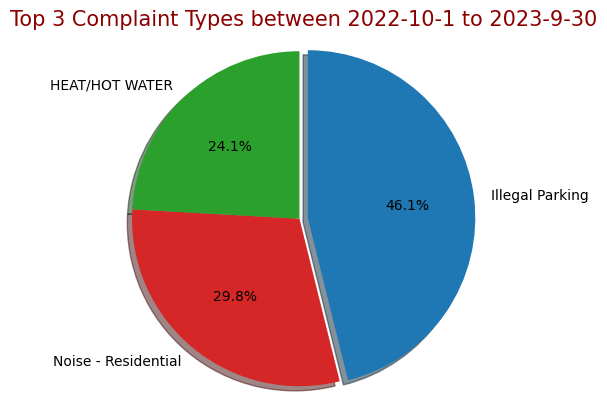

In [75]:
df_vis_1 = get_data_for_visual_1(conn)
plot_top_three_complaints_over_time(df_vis_1)

### Visualization 2 
     Displays the number of complaints by complaint type for the top 10 complaints in zip code 10027.

In [76]:
def get_data_for_visual_2(conn: connection) -> pd.DataFrame:
    """
    Retrieve data for Visualization 2: Top 10 complaint types for zip code 10027 between October 1, 2018, and September 30, 2023.

    Args:
        conn: Database connection object.
        
    Returns:
        pd.DataFrame: DataFrame containing complaint types and corresponding complaint numbers.
    """
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")

    cur = conn.cursor()
    start_date = date(2018, 10, 1)
    end_date = date(2023, 9, 30)
    QUERY = f'''
        SELECT
            complaint_type,
            COUNT(*) AS complaints_number
        FROM
            NYC_complaints
        WHERE 
            created_date BETWEEN '{start_date}' AND '{end_date}'
            AND
            zipcode ='10027'
        GROUP BY 
            complaint_type
        ORDER BY
            complaints_number DESC
        LIMIT 10;
    '''
    cur.execute(QUERY)
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=['complaint_type', 'complaints_number'])
    return df

In [77]:
def plot_top_ten_complaints_type_for_10027(dataframe: pd.DataFrame) -> None:
    """
    Plot a bar chart for the top ten complaint types for zip code 10027.

    Args:
        dataframe (pd.DataFrame): DataFrame containing complaint types and corresponding complaint numbers.

    Returns:
        None
    """
        
    if dataframe.empty:
        raise ValueError("DataFrame is empty")
    
    figure, axes = plt.subplots(figsize=(30, 20))
    complaint_type = dataframe['complaint_type']
    complaints_number = dataframe['complaints_number']

    # Create a color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(complaint_type)))

    bars = axes.bar(complaint_type, complaints_number, color=colors)

    axes.set_xlabel('Complaint Type', fontsize=24, color='darkblue')  # Set color for x-axis label
    axes.set_ylabel('Number of Complaints', fontsize=24, color='darkred')  # Set color for y-axis label
    axes.set_title("Top 10 Complaint Types for zip 10027 between 2018-10-1 to 2023-9-30", fontsize=40, color='purple')  # Set color for title

    # Increase font size of x-axis and y-axis ticks
    axes.tick_params(axis='both', labelsize=20)

    # Set tick positions at the middle of the bars
    middle_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars]
    axes.set_xticks(middle_positions)
    axes.set_xticklabels(complaint_type, rotation=45, ha="right", fontsize=18, color='green')  # Set color for x-axis tick labels

    plt.show()

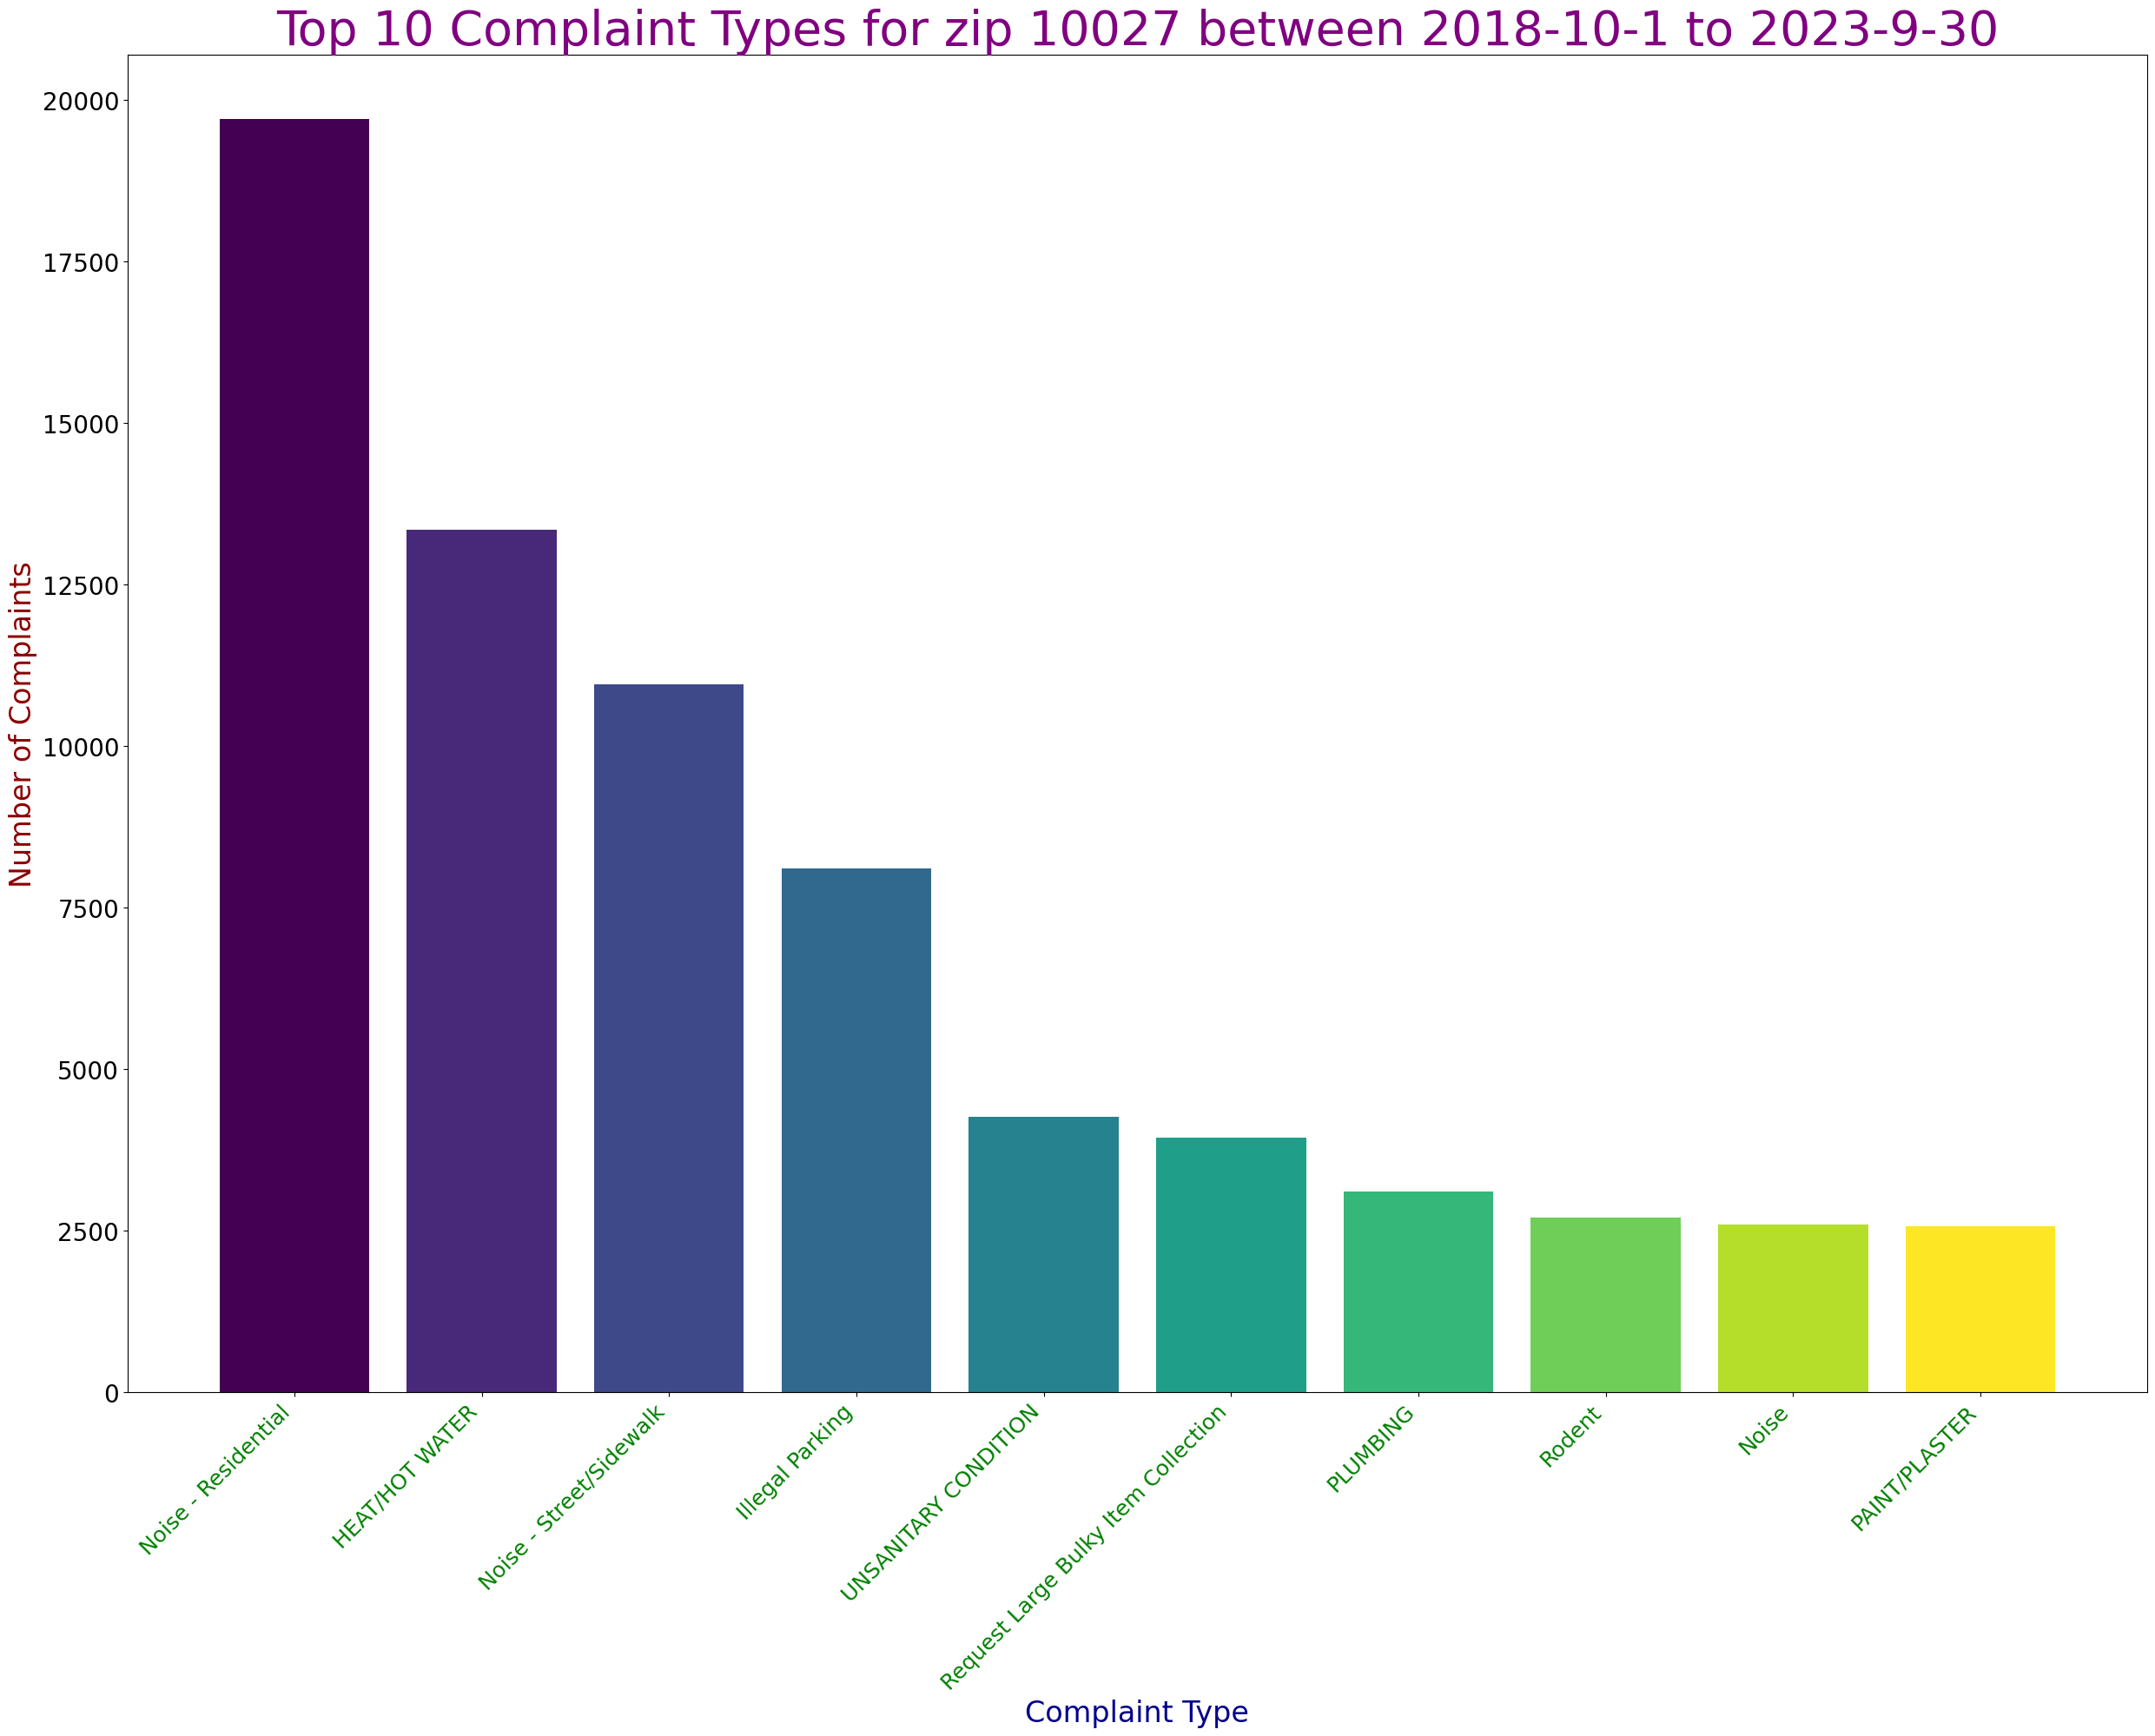

In [78]:
df_vis_2 = get_data_for_visual_2(conn)
plot_top_ten_complaints_type_for_10027(df_vis_2)

### Visualization 3
     Examines the correlation between rent, trees, and complaints over a specified timeframe.

In [79]:
def get_data_for_visual_3(conn: connection) -> pd.DataFrame:
    """
    Retrieve data from database for Visualization 3: Combined information about complaints, trees, and average rent by zip code.

    Args:
        conn: Database connection object.
        
    Returns:
        pd.DataFrame: DataFrame containing columns 'zipcode', 'num_complaints', 'num_trees', 'rents', 'avg_rent'.
    """
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")

    cur = conn.cursor()    
    start_date = date(2015, 1, 1)
    end_date = date(2023, 9, 30)
    query = f'''
        SELECT
            zipcode,
            COUNT(id) AS num_complaints
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY
            zipcode
    '''
    cur.execute(query)
    complaints_result = cur.fetchall()

    df_complaints = pd.DataFrame(complaints_result, columns=['zipcode', 'num_complaints'])
    
    query = f'''
    SELECT
        zipcode,
        COUNT(id) AS num_trees
    FROM
        NYC_trees
    WHERE
        created_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY
        zipcode
    '''

    cur.execute(query)
    trees_result = cur.fetchall()

    df_trees = pd.DataFrame(trees_result, columns=['zipcode', 'num_trees'])
    
    
    query = f'''
    SELECT
        zipcode,
        rents
    FROM
        NYC_rents r
    '''

    cur.execute(query)
    rent_result = cur.fetchall()

    # Convert to Pandas DataFrame

    df_rent = pd.DataFrame(rent_result, columns=['zipcode', 'rents'])
    df_rent['avg_rent'] = df_rent['rents'].apply(lambda x: np.nanmean(x))
    
    df_combined = pd.merge(df_complaints, df_trees, on='zipcode', how='inner')
    df_combined = pd.merge(df_combined, df_rent, on='zipcode', how='inner')
    
    return df_combined

In [80]:
def plot_rent_tree_complaint_coorelation(dataframe: pd.DataFrame) -> None:
    """
    Plot the correlation between average rent, the number of trees, and the number of complaints by zip code.

    Args:
        dataframe (pd.DataFrame): DataFrame containing columns 'avg_rent', 'num_trees', and 'num_complaints'.

    Returns:
        None
    """

    if dataframe.empty:
        raise ValueError("DataFrame is empty")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    
    dataframe = dataframe.fillna(0)

    # Plotting the first subplot (rent vs. number of trees)
    ax1.scatter(dataframe['avg_rent'], dataframe['num_trees'], color='blue', alpha=0.7)
    ax1.set_ylabel('Number of Trees', fontsize=14, color='darkblue')
    ax1.set_title('Rent vs. Number of Trees and Complaints by Zip Code', fontsize=16, color='purple')

    # Plotting the second subplot (rent vs. number of complaints)
    ax2.scatter(dataframe['avg_rent'], dataframe['num_complaints'], color='green', alpha=0.7)
    ax2.set_xlabel('Average Rent', fontsize=14, color='darkgreen')
    ax2.set_ylabel('Number of Complaints', fontsize=14, color='darkred')

    # Adjust font size for tick labels
    for ax in [ax1, ax2]:
        ax.tick_params(axis='both', labelsize=12)

    plt.show()

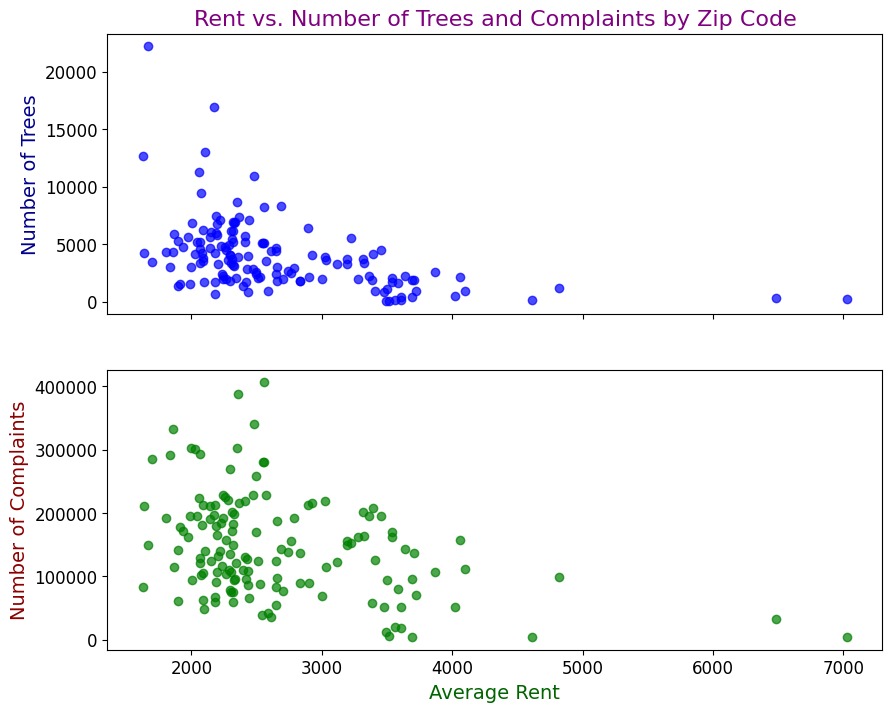

In [81]:
df_vis_3 = get_data_for_visual_3(conn)
plot_rent_tree_complaint_coorelation(df_vis_3)

### Visualization 4
    Uses a boxplot to explore the relationship between average rent and the number of 311 complaints observed in each zip code.

In [82]:
def get_data_for_visual_4(conn: connection) -> pd.DataFrame:
    """
    Retrieve data for visualizing the relationship between average rent and the number of 311 complaints.

    Args:
        conn: Database connection object.
        
    Returns:
        pd.DataFrame: DataFrame containing columns 'zipcode', 'rent', and 'num_complaints'.
    """
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")

    cur = conn.cursor() 
    start_date = date(2022, 10, 1)
    end_date = date(2023, 9, 30)
    i = rent_month_dict['2023-09-30']
    QUERY = f'''
        SELECT 
            zipcode, 
            rents[{i}] AS avg_rent
        FROM 
            NYC_rents r
    '''
    cur.execute(QUERY)
    result = cur.fetchall()
    df_rent = pd.DataFrame(result, columns=['zipcode', 'rent'])
    query = f'''
        SELECT
            zipcode,
            COUNT(id) AS num_complaints
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY
            zipcode
    '''
    cur.execute(query)
    complaints_result = cur.fetchall()

    df_complaints = pd.DataFrame(complaints_result, columns=['zipcode', 'num_complaints'])
    df_combined = pd.merge(df_rent, df_complaints, on='zipcode', how='outer')
    return df_combined

In [83]:
def plot_rent_complaint_coorelation(dataframe: pd.DataFrame) -> None:
    """
    Plot the relationship between average rent and the number of 311 complaints using a boxplot.

    Args:
        dataframe (pd.DataFrame): DataFrame containing columns 'rent', 'num_complaints', and 'rent_bin'.

    Returns:
        None
    """
    if dataframe.empty:
        raise ValueError("DataFrame is empty")
    
    # Create bins for average rent
    bins = range(0, 9000, 1000) 

    # Categorize average rent into bins
    dataframe['rent_bin'] = pd.cut(dataframe['rent'], bins, right=False)

    # Create a boxplot using Seaborn
    plt.figure(figsize=(14, 12))
    sns.boxplot(x='rent_bin', y='num_complaints', hue='rent_bin', data=dataframe, palette='viridis', dodge=True, showfliers=True, legend=False, widths=0.4)
    plt.xlabel('Average Rent Bins ($)', fontsize=14, color='darkblue')
    plt.ylabel('Number of 311 Complaints', fontsize=14, color='darkred')
    plt.title('Relationship Between Average Rent and 311 Complaints', fontsize=16, color='purple')
    plt.xticks(rotation=45)

    # Adjust font size for tick labels
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')

    plt.show()

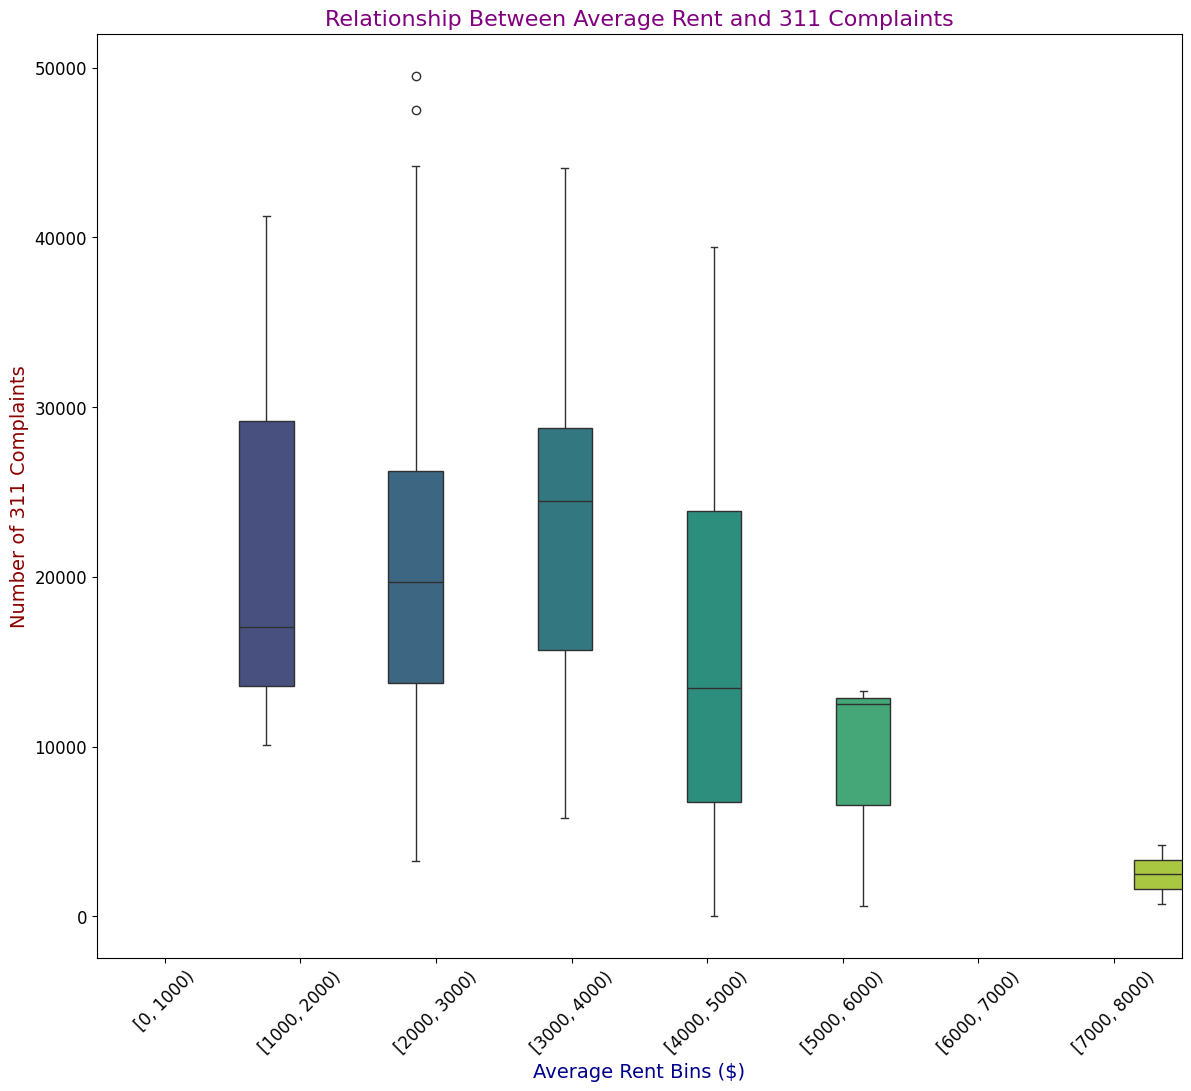

In [84]:
df_vis_4 = get_data_for_visual_4(conn)
plot_rent_complaint_coorelation(df_vis_4)

### Visualization 5
    Presents a geospatial plot of the coordinates of reported 311 incidents within a 1-kilometer radius of a specific coordinate.

In [85]:
def get_data_for_visual_5(conn: connection) -> gpd.GeoDataFrame:
    """
    Retrieve data for visualizing 311 complaints with their coordinates.

    Args:
        conn: Database connection object.
        
    Returns:
        gpd.GeoDataFrame: GeoDataFrame containing 311 complaints data with coordinates.
    """
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")

    cur = conn.cursor() 
    start_date = date(2023, 1, 1)
    end_date = date(2023, 9, 30)
    query = f'''
        SELECT
            id,
            created_date,
            ST_AsText(location) AS coordinate
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}';
    '''
    cur.execute(query)
    complaints_result = cur.fetchall()

    df_complaints = pd.DataFrame(complaints_result, columns=['id', 'created_date', 'coordinate'])
    df_complaints["coordinate"] = gpd.GeoSeries.from_wkt(df_complaints["coordinate"])
    gdf_complaints = gpd.GeoDataFrame(df_complaints, geometry='coordinate')
    return gdf_complaints

In [86]:
def plot_311_complaints_near_campus(gdf: gpd.GeoDataFrame) -> None:
    """
    Plot 311 incidents within a 1 km radius of a specified coordinate.

    Args:
        dataframe (gpd.GeoDataFrame): GeoDataFrame containing the 311 incidents data.

    Returns:
        None
    """
    if gdf.empty:
        raise ValueError("DataFrame is empty")
        
    buffer_radius = 1000  # 1 kilometer in meters
    central_coordinate = Point(-73.96253174434912, 40.80737875669467)
    buffer_geometry = central_coordinate.buffer(buffer_radius / 111000)  # Convert meters to degrees
    
    gdf_buffer = gpd.GeoDataFrame(geometry=[buffer_geometry], crs=CRS)
    
    points_within_buffer = gdf[gdf.geometry.within(gdf_buffer.geometry.iloc[0])]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_buffer.plot(ax=ax, color='lightgreen', alpha=0.5, label='Buffer around Specified Coordinate')
    points_within_buffer.plot(ax=ax, color='red', markersize=50, label='311 Incidents')
    # Manually create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='311 Incidents')]

    ax.legend(handles=legend_elements)
    
    plt.title('Geospatial Plot of 311 Incidents within 1 km Radius of campus coordinate', fontsize=15, color='blue')
    #legend_elements = [Patch(color='lightgreen', alpha=0.5, label='Buffer around Specified Coordinate'),
    plt.legend(handles=legend_elements)

    # Show the plot
    plt.show()

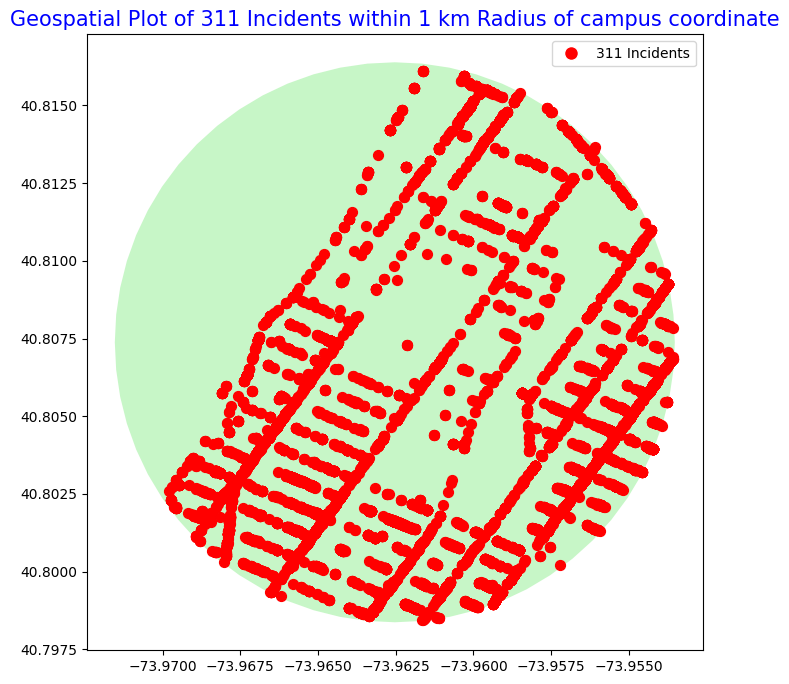

In [87]:
gdf_vis_5 = get_data_for_visual_5(conn)
plot_311_complaints_near_campus(gdf_vis_5)

### Visualization 6
    Depicts a geospatial plot of coordinates for trees and "New Tree Request" 311 complaint types to explore areas trying to improve the number of trees in the neighborhood.

In [9]:
def get_data_for_visual_6(conn: connection) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Fetch geospatial data for NYC trees and complaints within a specified date range.

    Args:
        conn: Database connection object.
        
    Returns:
        Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]: GeoDataFrames for NYC trees, complaints and zipcodes.
    """
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")

    cur = conn.cursor() 
    start_date = date(2018, 10, 1)
    end_date = date(2023, 9, 30)
    trees_query = f'''
        SELECT
            id,
            created_date,
            zipcode,
            ST_AsText(location) AS coordinate
        FROM
            NYC_trees
    '''
    cur.execute(trees_query)
    trees_result = cur.fetchall()
    
    
    complains_query = f'''
        SELECT
            id,
            created_date,
            zipcode,
            complaint_type,
            ST_AsText(location) AS coordinate
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}'
    '''
    cur.execute(complains_query)
    complaints_result = cur.fetchall()
    
    zip_codes_query = f'''
        SELECT
            zipcode,
            ST_AsText(geometry) AS geometry
        FROM
            NYC_zipcodes
    '''
    
    cur.execute(zip_codes_query)
    zipcode_result = cur.fetchall()
    
    df_trees = pd.DataFrame(trees_result, columns=['id','created_date', 'zipcode', 'coordinate'])
    df_trees["coordinate"] = gpd.GeoSeries.from_wkt(df_trees["coordinate"])
    gdf_trees = gpd.GeoDataFrame(df_trees, geometry='coordinate')
    gdf_trees.dropna(inplace=True)
    
    df_complaints = pd.DataFrame(complaints_result, columns=['id', 'created_date', 'zipcode', 'complaint_type', 'coordinate'])
    df_complaints["coordinate"] = gpd.GeoSeries.from_wkt(df_complaints["coordinate"])
    gdf_complaints = gpd.GeoDataFrame(df_complaints, geometry='coordinate')
    gdf_complaints.dropna(inplace=True)
    
    df_zipcodes = pd.DataFrame(zipcode_result, columns=['zipcode', 'geometry'])
    df_zipcodes["geometry"] = gpd.GeoSeries.from_wkt(df_zipcodes["geometry"])
    gdf_zipcodes = gpd.GeoDataFrame(df_zipcodes, geometry='geometry')
    
    return gdf_trees, gdf_complaints, gdf_zipcodes

In [15]:
def plot_NYC_trees_complaints(
    gdf_trees: gpd.GeoDataFrame,
    gdf_complaints: gpd.GeoDataFrame,
    gdf_zipcodes: gpd.GeoDataFrame
) -> None: 
    """
    Plot visualization for NYC trees and 311 complaints using pointplot and choropleth.

    Args:
        gdf_trees (gpd.GeoDataFrame): GeoDataFrame containing NYC trees data.
        gdf_complaints (gpd.GeoDataFrame): GeoDataFrame containing NYC 311 complaints data.
        gdf_zipcodes (gpd.GeoDataFrame): GeoDataFrame containing NYC zipcodes geometry data.
        
    Returns:
        None
    """
    if gdf_trees.empty or gdf_complaints.empty or gdf_zipcodes.empty:
        raise ValueError("DataFrame is empty")
        
    gdf_complaints = gdf_complaints[gdf_complaints['complaint_type'] == "New Tree Request"]
    complaints_per_zipcodes = gdf_complaints.groupby(['zipcode']).count()['id']
    complaints_per_zipcodes.name = "complaints_count"
    gdf_combined = gpd.GeoDataFrame(
        pd.merge(complaints_per_zipcodes, gdf_zipcodes, on='zipcode', how='left')
    )
    
    gdf_trees['created_date'] = pd.to_datetime(gdf_trees['created_date'])
    gdf_trees['year_month'] = gdf_trees['created_date'].dt.to_period('M')
    gdf_trees['year_month'] = gdf_trees['year_month'].dt.to_timestamp()
    gdf_trees['numeric_representation'] = gdf_trees['year_month'].dt.year * 100 + gdf_trees['year_month'].dt.month
                          
    # Sample 5000 points from gdf_trees_2015
    gdf_trees_sampled = gdf_trees.sample(n=5000, random_state=42)

    # Create a GeoAxes subplot
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': gcrs.PlateCarree()})

    # Add trees sampled points to the map using gplt.pointplot
    ax = gplt.pointplot(
        gdf_trees_sampled,
        hue="numeric_representation",  
        cmap="Reds",
        scheme="quantiles",
        legend=True,
        scale="numeric_representation", 
        alpha=1.0,
        limits=(1, 5),  
        legend_var="hue", 
        legend_labels=[
            "May 2015 - Aug 2015", "Aug 2015 - Oct 2015",
            "Oct 2015 - Nov 2015", "Nov 2015 - Jun 2016",
            "Jun 2016 - Oct 2016"
        ], 
        ax=ax  
    )

    # Add choropleth map of aggregated complaints
    ax = gplt.choropleth(
        gdf_combined,
        hue="complaints_count", 
        edgecolor="white",
        linewidth=0.4,  
        cmap="Blues",
        alpha=0.5,
        legend=True,  
        legend_kwargs={'orientation': 'horizontal', 'label': 'New Tree Request'},
        ax=ax,  
    )
    
    ax.set_title("Geospatial Plot of NYC New Tree Request and NYC Trees Over Time", fontsize=20, color='green')
    # Show the plot
    plt.show()               

In [10]:
gdf_trees, gdf_complaints, gdf_zipcodes = get_data_for_visual_6(conn)

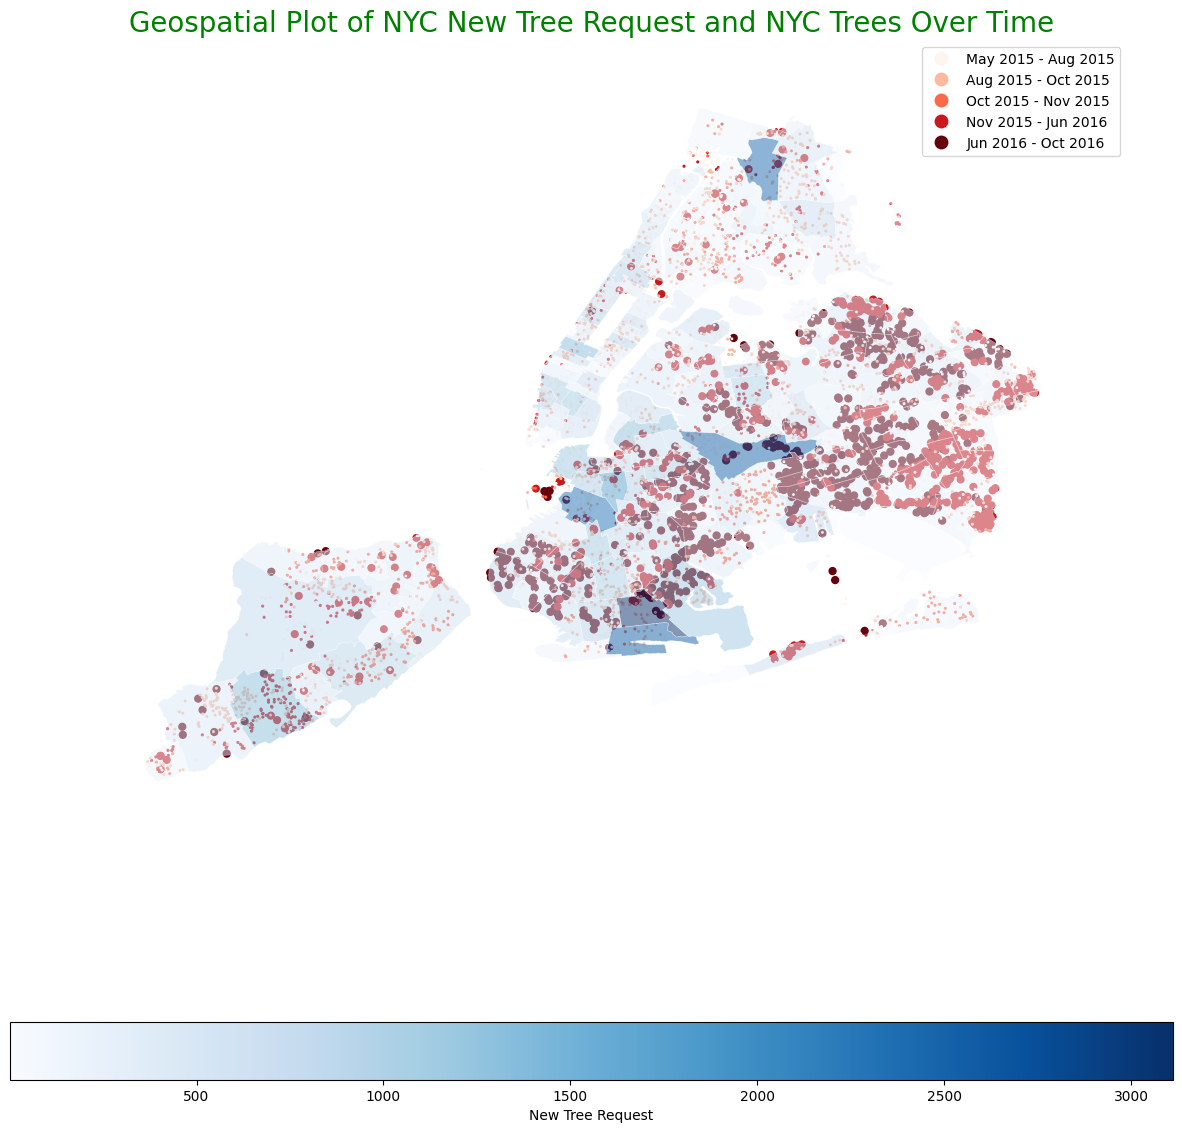

In [16]:
plot_NYC_trees_complaints(gdf_trees, gdf_complaints, gdf_zipcodes)

## Extra Credit Plot animations
    Display the rent and complaints trend for zipcode 10001

In [92]:
def get_data_for_animation_visual(conn: connection) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fetch geospatial data for NYC rents and complaints.

    Args:
        conn: Database connection object.
        
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame] for NYC rents, complaints.
    """    
    if not isinstance(conn, connection):
        raise ValueError("The provided object is not a psycopg2.extensions.connection object.")

    cur = conn.cursor() 
    rent_query = f'''
        SELECT 
            zipcode, 
            rents AS avg_rent
        FROM 
            NYC_rents 
        WHERE
            zipcode = '10001'
    '''
    cur.execute(rent_query)
    rent_result = cur.fetchall()
    
    complaints_query = f'''
        SELECT
            created_date,
            COUNT(id) AS num_complaints
        FROM
            NYC_complaints
        WHERE
            zipcode = '10001'
        GROUP BY
            created_date
    '''
    cur.execute(complaints_query)
    complaints_result = cur.fetchall()

    df_complaints = pd.DataFrame(complaints_result, columns=['created_date', 'num_complaints'])
    df_rent = pd.DataFrame(rent_result, columns=['zipcode', 'rent'])
    
    return df_rent, df_complaints

In [93]:
def plot_rent_complaints_in_month_animated(df_rent: pd.DataFrame, df_complaints: pd.DataFrame) -> FuncAnimation:
    """
    Plot animation visualization for NYC complaints and rents data in month.

    Args:
        df_rent (pd.DataFrame): DataFrame containing rent data.
        df_complaints (pd.DataFrame): DataFrame containing complaints data.
  
    Returns:
        FuncAnimation: Matplotlib FuncAnimation object.
    """
    # enables the interactive notebook backend, which is necessary for displaying animations 
    %matplotlib notebook 
    if df_rent.empty or df_complaints.empty:
        raise ValueError("DataFrame is empty")
    df_complaints['date'] = pd.to_datetime(df_complaints['created_date'])
    df_complaints['month'] = df_complaints['date'].dt.to_period('M')
    complaints_by_month = df_complaints.groupby('month')['num_complaints'].sum()
    complaints_by_month.reset_index()
    df_rent_month = pd.DataFrame({'Month': list(rent_month_dict.keys()), 'Rent': df_rent['rent'].tolist()[0]})
    df_rent_month['Month'] = pd.to_datetime(df_rent_month['Month'])
    df_rent_month['Month'] = df_rent_month['Month'].dt.to_period('M')
    merged_df = df_rent_month.merge(complaints_by_month, left_on='Month', right_on='month', how='left')

    # Convert 'Month' to a string and then to datetime
    merged_df['Month'] = pd.to_datetime(merged_df['Month'].astype(str))

    # Sort the DataFrame by 'Month' 
    merged_df = merged_df.sort_values(by='Month')

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))

    # Plot Rent on the first y-axis
    line1, = ax1.plot([], [], label='Rent', color='b')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Rent', color='b')

    # Plot Num Complaints on the second y-axis
    line2, = ax2.plot([], [], label='Num Complaints', color='r')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Num Complaints', color='r')

    # Title and legend
    plt.legend()

    # Animation function
    def update(frame):
        ax1.clear()  # Clear previous data in the first subplot
        ax2.clear()  # Clear previous data in the second subplot

        # Plot Rent on the first y-axis
        ax1.plot(merged_df['Month'][:frame], merged_df['Rent'][:frame], label='Rent', color='b')
        ax1.set_xlabel('Month')
        ax1.set_ylabel('Rent', color='b')

        # Plot Num Complaints on the second y-axis
        ax2.plot(merged_df['Month'][:frame], merged_df['num_complaints'][:frame], label='Num Complaints', color='r')
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Num Complaints', color='r')
        
        
        ax1.legend()
        ax2.legend()
        return line1, line2


    animation = FuncAnimation(fig, update, frames=len(merged_df), interval=100)
    plt.show()
    return animation # keep animation alive

In [94]:
df_rent, df_complaints = get_data_for_animation_visual(conn)

<IPython.core.display.Javascript object>


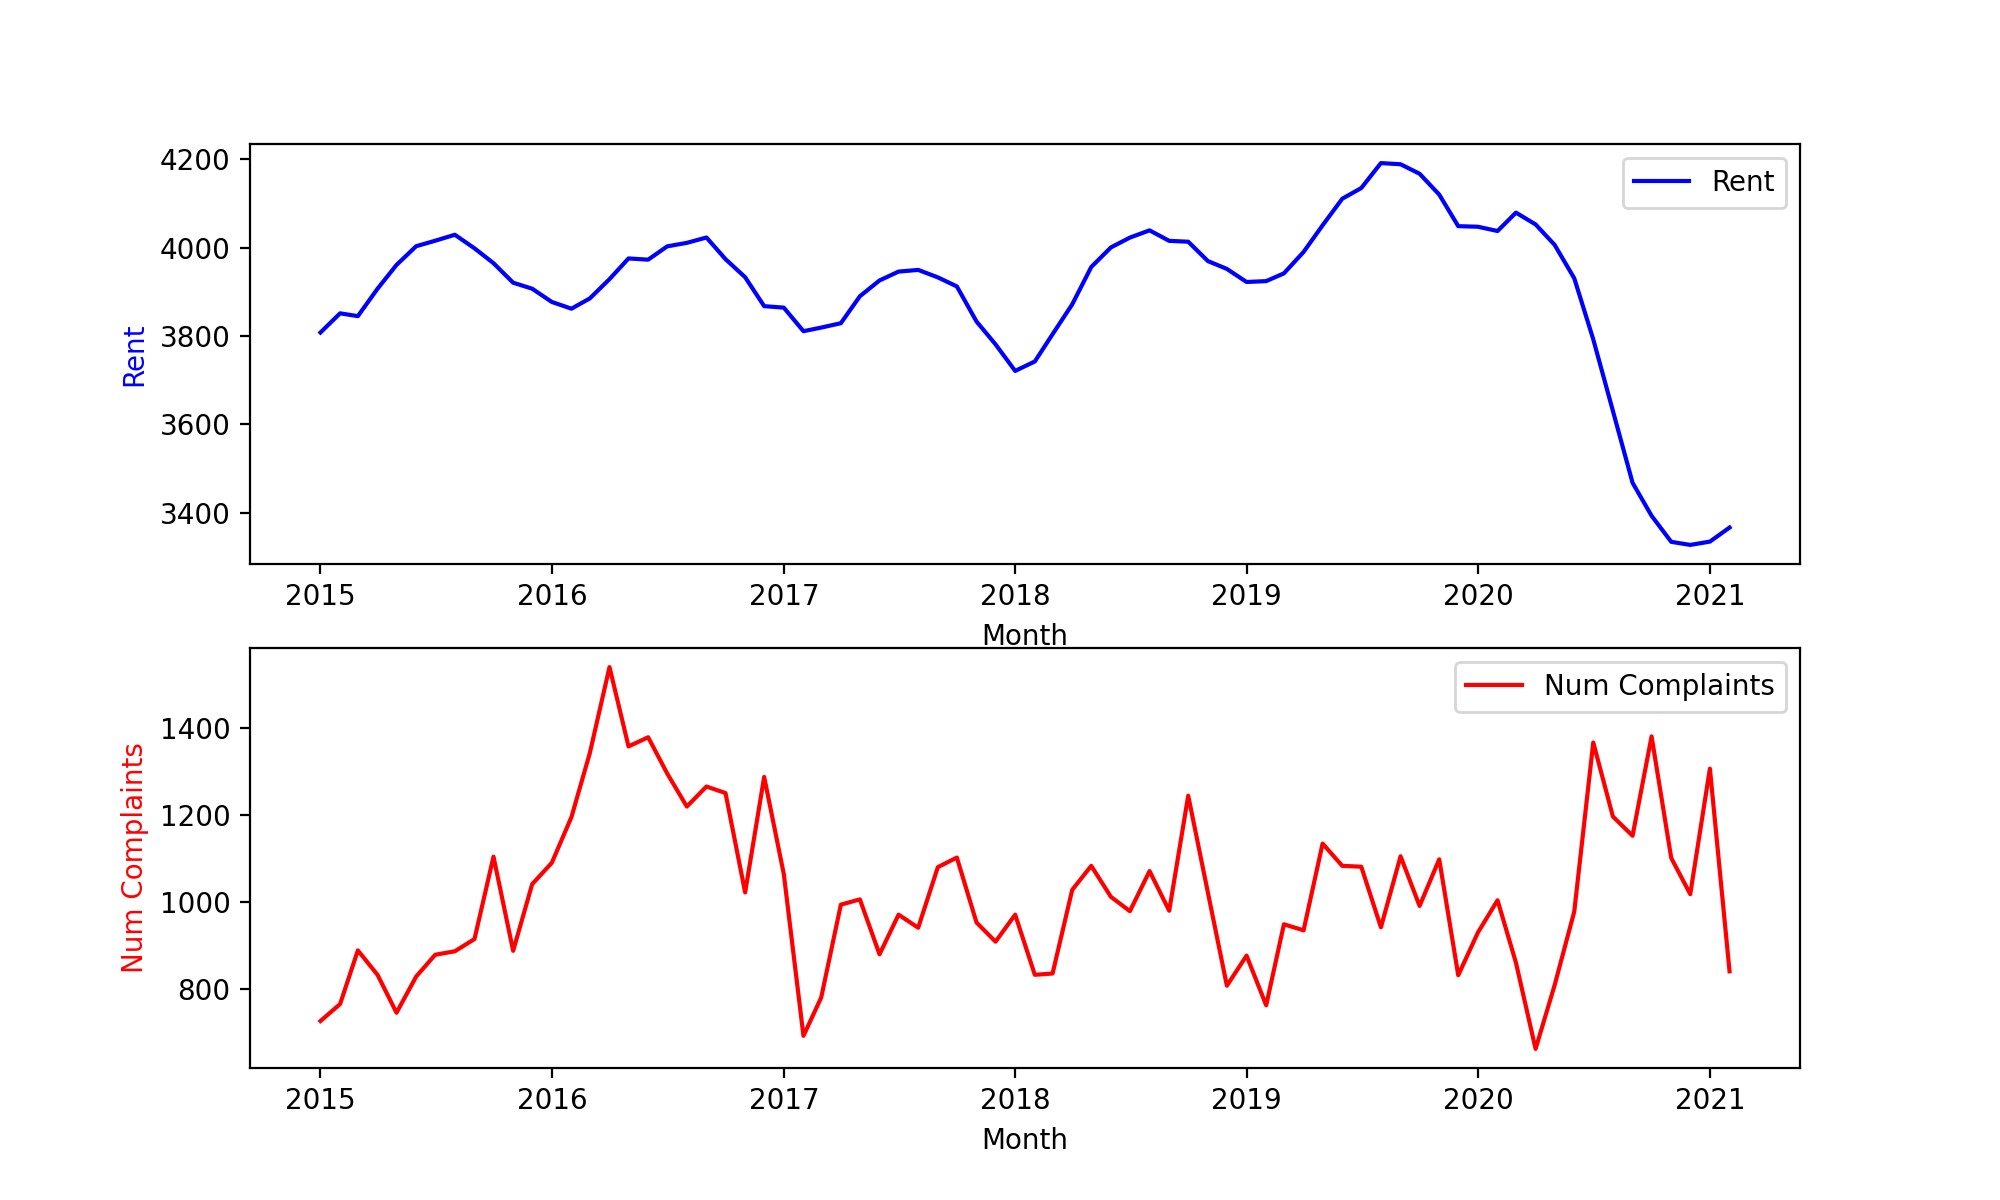

In [95]:
plot_rent_complaints_in_month_animated(df_rent, df_complaints)

# Unit Test

### Test for part1

In [96]:
def test_download_and_clean_311_data() -> None:
    cleaned_data = download_and_clean_311_data()
    assert isinstance(cleaned_data, gpd.GeoDataFrame)

In [97]:
def test_download_nyc_311_data() -> None:
    with pytest.raises(ConnectionError):
        download_nyc_311_data("https://www.example.com/data", force=True)

In [98]:
def test_download_nyc_tree_data() -> None:
    result = download_nyc_tree_data(f"{BASE_NYC_DATA_URL}/{NYC_DATA_TREES}", force=False)
    print(result)
    assert result == Path("data/5rq2-4hqu.json")

In [99]:
def test_load_and_clean_zipcodes() -> None:
    with pytest.raises(FileNotFoundError):
        load_and_clean_zipcodes(Path("invalid_path/to/shapefile.shp"))

In [100]:
def test_download_and_clean_tree_data() -> None:
    cleaned_data = download_and_clean_tree_data()
    assert isinstance(cleaned_data, gpd.GeoDataFrame)

In [101]:
def test_load_and_clean_zillow_data() -> None:
    with pytest.raises(FileNotFoundError):
        load_and_clean_zillow_data(Path("invalid_path/to/zillow.csv"))

In [102]:
def test_load_all_data() -> None:
    result = load_all_data()
    assert len(result) == 4

In [103]:
def test_download_nyc_business_data() -> None:
    result = download_nyc_business_data(f"{BASE_NYC_DATA_URL}/{NYC_DATA_BUSINESS}", force=False)
    assert result == Path("data/w7w3-xahh.json")

In [104]:
def test_download_and_clean_business_data() -> None:
    cleaned_data = download_and_clean_business_data()
    assert isinstance(cleaned_data, pd.DataFrame)

### Test for part 2

In [105]:
def test_setup_new_postgis_database() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    assert isinstance(conn, psycopg2.extensions.connection)

In [106]:
def test_create_table_and_index() -> None:
    conn = "fake_connection"
    with pytest.raises(ValueError):
        gdf = create_table_and_index(conn)

In [107]:
def test_zipcodes_write_to_table() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    with pytest.raises(TypeError):
        zipcodes_write_to_table(123, conn)
        
def test_rents_write_to_table() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    with pytest.raises(AttributeError):
        rents_write_to_table(123, conn)
        
def test_trees_write_to_table() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    with pytest.raises(TypeError):
        trees_write_to_table(123, conn)
        
def test_complaints_write_to_table() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    with pytest.raises(TypeError):
        trees_write_to_table(123, conn)
        
def test_write_dataframes_to_tables() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    with pytest.raises(TypeError):
        write_dataframes_to_tables(123, conn)
        
def test_business_data_write_to_table() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    with pytest.raises(TypeError):
        business_data_write_to_table(123, conn)

### Test for part 3

In [108]:
def test_write_query_to_file() -> None:
    # Create a temporary file for testing
    outfile_path = os.path.join(QUERY_DIR, "test_query.sql")
    # Call the function with a sample query
    query = "SELECT * FROM table;"
    write_query_to_file(query, outfile_path)

    assert os.path.exists(outfile_path)
    os.remove(outfile_path)

In [109]:
def test_write_all_queries_to_file() -> None:
    write_all_queries_to_file()
    assert os.path.exists(QUERY_1_FILENAME)

### Test for part 4

In [110]:
def test_get_data_for_visual_1() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    df = get_data_for_visual_1(conn)

    # Check if the returned object is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Check if the DataFrame has the expected columns
    assert 'complaint_type' in df.columns
    assert 'complaints_number' in df.columns

def test_plot_top_three_complaints_over_time() -> None:
    df = pd.DataFrame()

    with pytest.raises(ValueError):
        plot_top_three_complaints_over_time(df)

In [111]:
def test_get_data_for_visual_2() -> None:
    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    df = get_data_for_visual_2(conn)

    # Check if the returned object is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Check if the DataFrame has the expected columns
    assert 'complaint_type' in df.columns
    assert 'complaints_number' in df.columns
    
def test_plot_top_ten_complaints_type_for_10027() -> None:
    df = pd.DataFrame()

    with pytest.raises(ValueError):
        plot_top_ten_complaints_type_for_10027(df)

In [112]:
def test_get_data_for_visual_3() -> None:

    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    df = get_data_for_visual_3(conn)

    # Check if the returned object is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Check if the DataFrame has the expected columns
    assert 'zipcode' in df.columns
    
def test_plot_rent_tree_complaint_coorelation():
    df = pd.DataFrame()

    with pytest.raises(ValueError):
        plot_rent_tree_complaint_coorelation(df)

In [113]:
def test_get_data_for_visual_4():

    conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)
    df = get_data_for_visual_4(conn)

    # Check if the returned object is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Check if the DataFrame has the expected columns
    assert 'zipcode' in df.columns
    
def test_plot_rent_complaint_coorelation():
    df = pd.DataFrame()

    with pytest.raises(ValueError):
        plot_rent_complaint_coorelation(df)

In [114]:
def test_get_data_for_visual_5():
    conn = "fake_connection"
    with pytest.raises(ValueError):
        gdf = get_data_for_visual_5(conn)
    
def test_plot_311_complaints_near_campus():
    gdf = gpd.GeoDataFrame

    with pytest.raises(ValueError):
        plot_311_complaints_near_campus(gdf)

In [115]:
def test_get_data_for_visual_6():

    conn = "fake_connection"
    with pytest.raises(ValueError):
        gdf = get_data_for_visual_6(conn)


def test_plot_NYC_trees_complaints():
    gdf_trees= gpd.GeoDataFrame()
    gdf_complaints= gpd.GeoDataFrame()
    gdf_zipcodes= gpd.GeoDataFrame()

    with pytest.raises(ValueError):
        plot_NYC_trees_complaints(gdf_trees, gdf_complaints, gdf_zipcodes)

In [116]:
def test_get_data_for_animation_visual():
    
    conn = 123
    with pytest.raises(ValueError):
        gdf = get_data_for_visual_6(conn)


def test_plot_rent_complaints_in_month_animated():
    df_rent = pd.DataFrame()
    df_complaints = pd.DataFrame()

    with pytest.raises(ValueError):
        plot_rent_complaints_in_month_animated(df_rent, df_complaints)

In [119]:
ipytest.run("-v")

======================================= test session starts ========================================
platform darwin -- Python 3.11.5, pytest-7.4.3, pluggy-1.3.0 -- /Library/Frameworks/Python.framework/Versions/3.11/bin/python3.11
cachedir: .pytest_cache
rootdir: /Users/minlisong/Desktop/4501-TooL-For-Analytics/Final_project
collecting ... collected 33 items

t_fc98df895dcd4effbb0d83febc04fde1.py::test_download_and_clean_311_data PASSED               [  3%]
t_fc98df895dcd4effbb0d83febc04fde1.py::test_download_nyc_311_data PASSED                     [  6%]
t_fc98df895dcd4effbb0d83febc04fde1.py::test_download_nyc_tree_data PASSED                    [  9%]
t_fc98df895dcd4effbb0d83febc04fde1.py::test_load_and_clean_zipcodes PASSED                   [ 12%]
t_fc98df895dcd4effbb0d83febc04fde1.py::test_download_and_clean_tree_data PASSED              [ 15%]
t_fc98df895dcd4effbb0d83febc04fde1.py::test_load_and_clean_zillow_data PASSED                [ 18%]
t_fc98df895dcd4effbb0d83febc04fde1.py:

<ExitCode.OK: 0>